In [5]:
import polars as pl
from data_v2 import get_table
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

# 1) Table Creation 

In [6]:
compound = get_table("compound")
well = get_table("well")
plate = get_table("plate")
micro = get_table("microscope_config")
target2 = get_table("target2")
#target2_plate = get_table("target2_plate")

In [7]:
# Rename the source 13 into source 7
well = well.with_columns(
    pl.when(pl.col("Metadata_Source").str.contains("_13$"))
    .then(pl.lit("source_7"))
    .otherwise(pl.col("Metadata_Source"))
    .alias("Metadata_Source"))

# Removal of source_9 and source_1.
well = well.filter(pl.col("Metadata_Source").str.contains("_9|_1$") != True)

plate = plate.select(pl.all().exclude("Metadata_Source"))

micro_features = ['Metadata_Source','Metadata_Microscope_Name',
                  'Metadata_Widefield_vs_Confocal',
                  'Metadata_Excitation_Type',
                  'Metadata_Objective_NA',
                  'Metadata_Filter_Configuration']
micro = micro.with_columns(
    ("source_" + pl.col("Metadata_Source").cast(str)).alias("Metadata_Source")).select(
    pl.col(micro_features))


In [8]:
micro = micro.filter(pl.col("Metadata_Source").str.contains("_[19]$|_15$|_13$") != True)
map_micro_ID = micro.select(pl.col("Metadata_Source"),
                            pl.struct(pl.all().exclude("Metadata_Source")).alias("unique"))\
                            .sort(by="unique")\
                            .select(pl.col("Metadata_Source"), pl.col("unique").rle_id().alias("Micro_id"))

micro = micro.join(map_micro_ID,
           on="Metadata_Source",
           how="left")

In [9]:
merge_table = compound.join(well, on=pl.col("Metadata_JCP2022"), how="inner")\
.join(plate, on=pl.col("Metadata_Plate"), how="inner")\
.join(micro, on=pl.col("Metadata_Source"), how="inner")\
.join(target2,left_on=pl.col("Metadata_InChIKey"), right_on=pl.col("InChIKey"), how="inner")

merge_table = merge_table.unique()


In [10]:
merge_table.shape

(228748, 22)

In [11]:
merge_table.select(pl.all().n_unique())

Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_Batch,Metadata_PlateType,Metadata_Microscope_Name,Metadata_Widefield_vs_Confocal,Metadata_Excitation_Type,Metadata_Objective_NA,Metadata_Filter_Configuration,Micro_id,broad_sample,pert_iname,pubchem_cid,target,pert_type,control_type,smiles,InChI
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
302,302,302,9,2174,384,126,8,5,2,2,2,6,7,307,303,298,161,2,5,302,302


# 2) Analysis of the Table distribution of compounds among sources or well. 

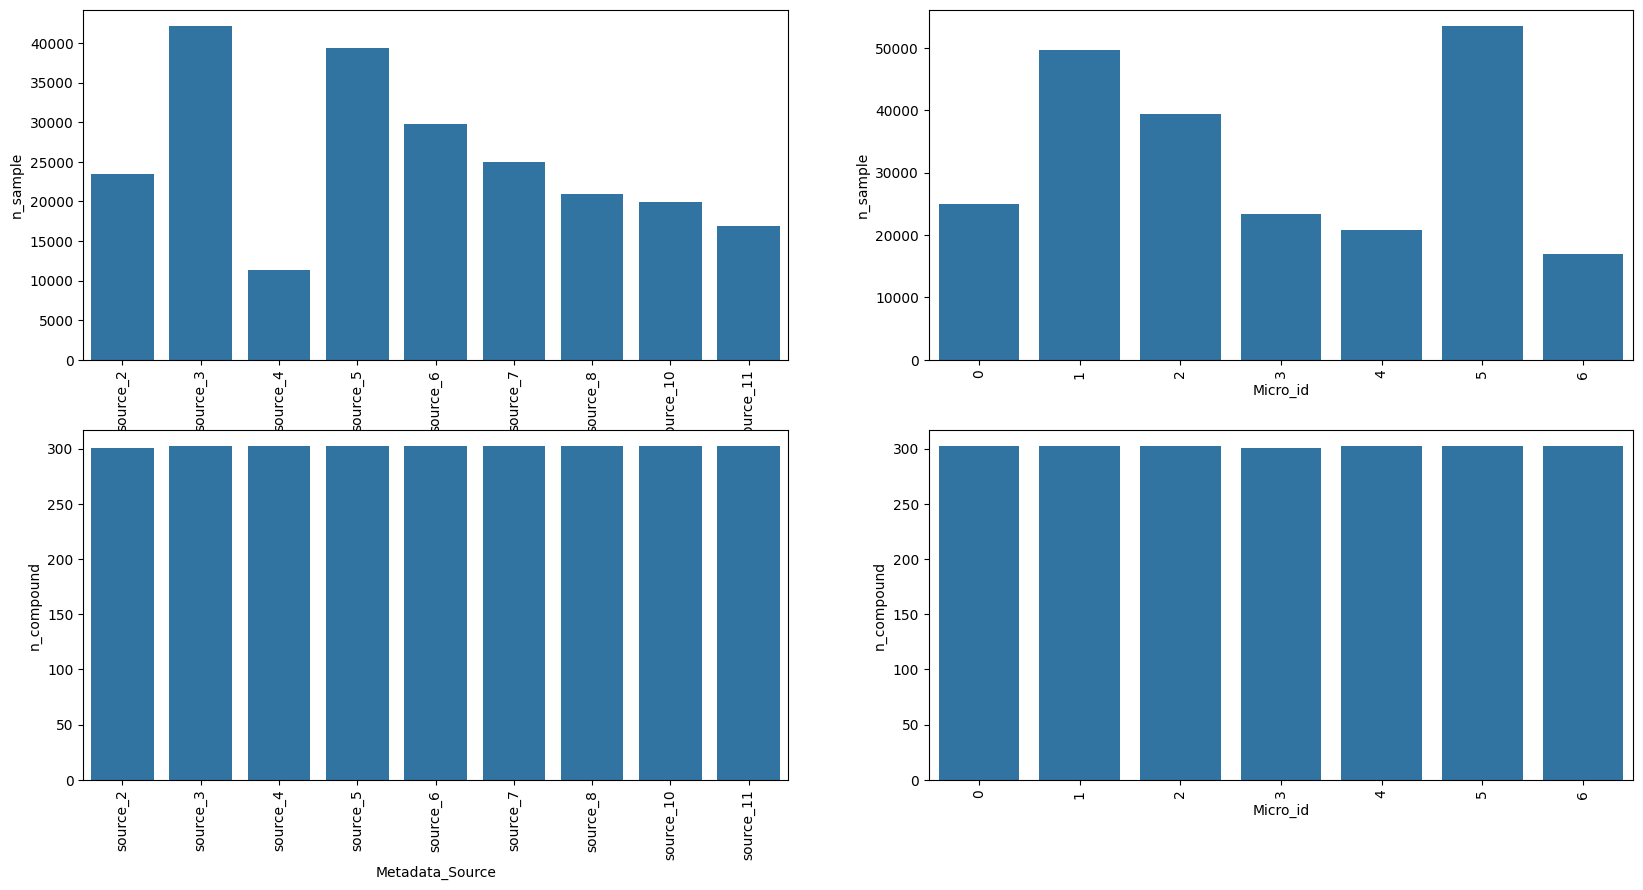

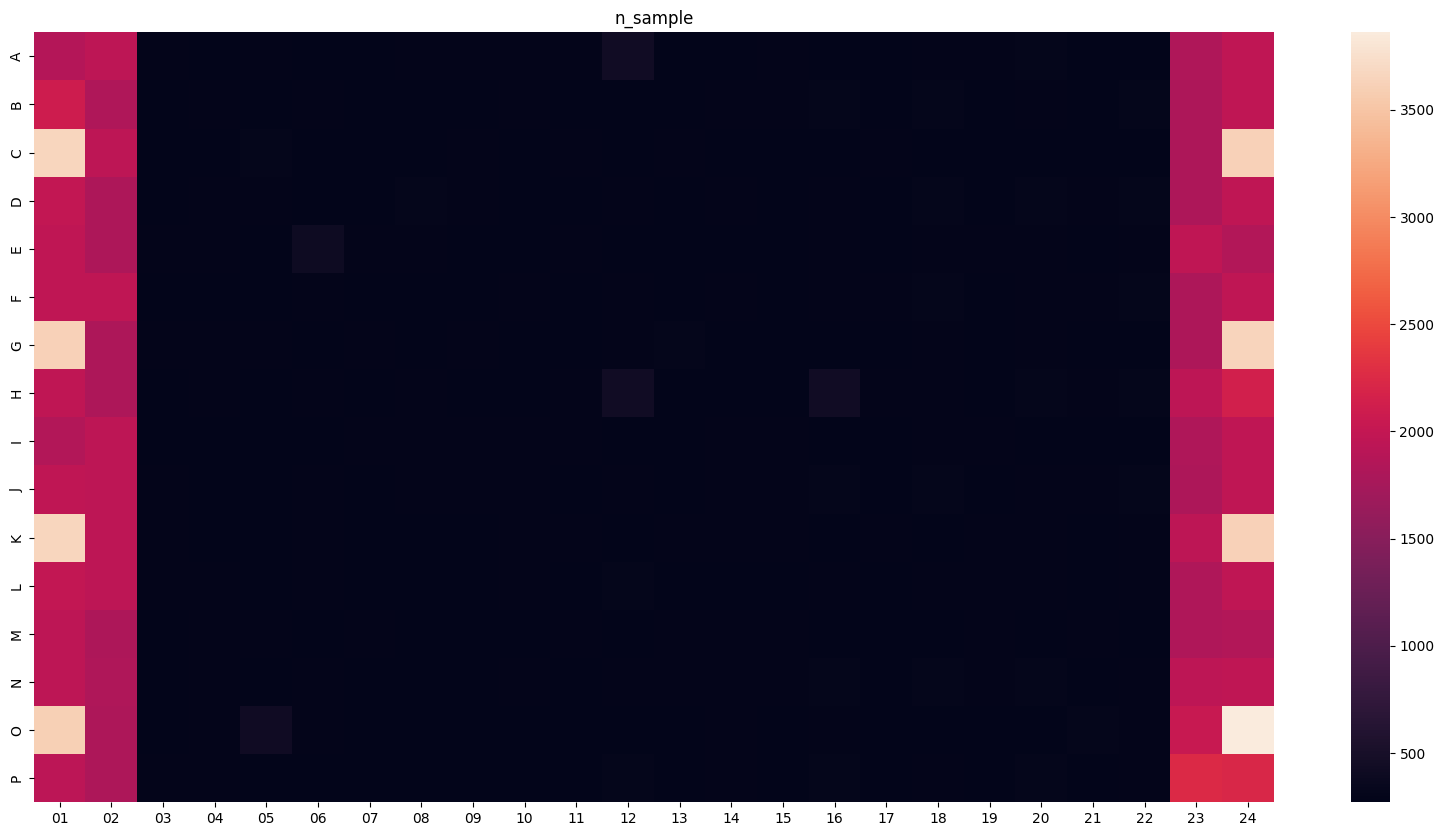

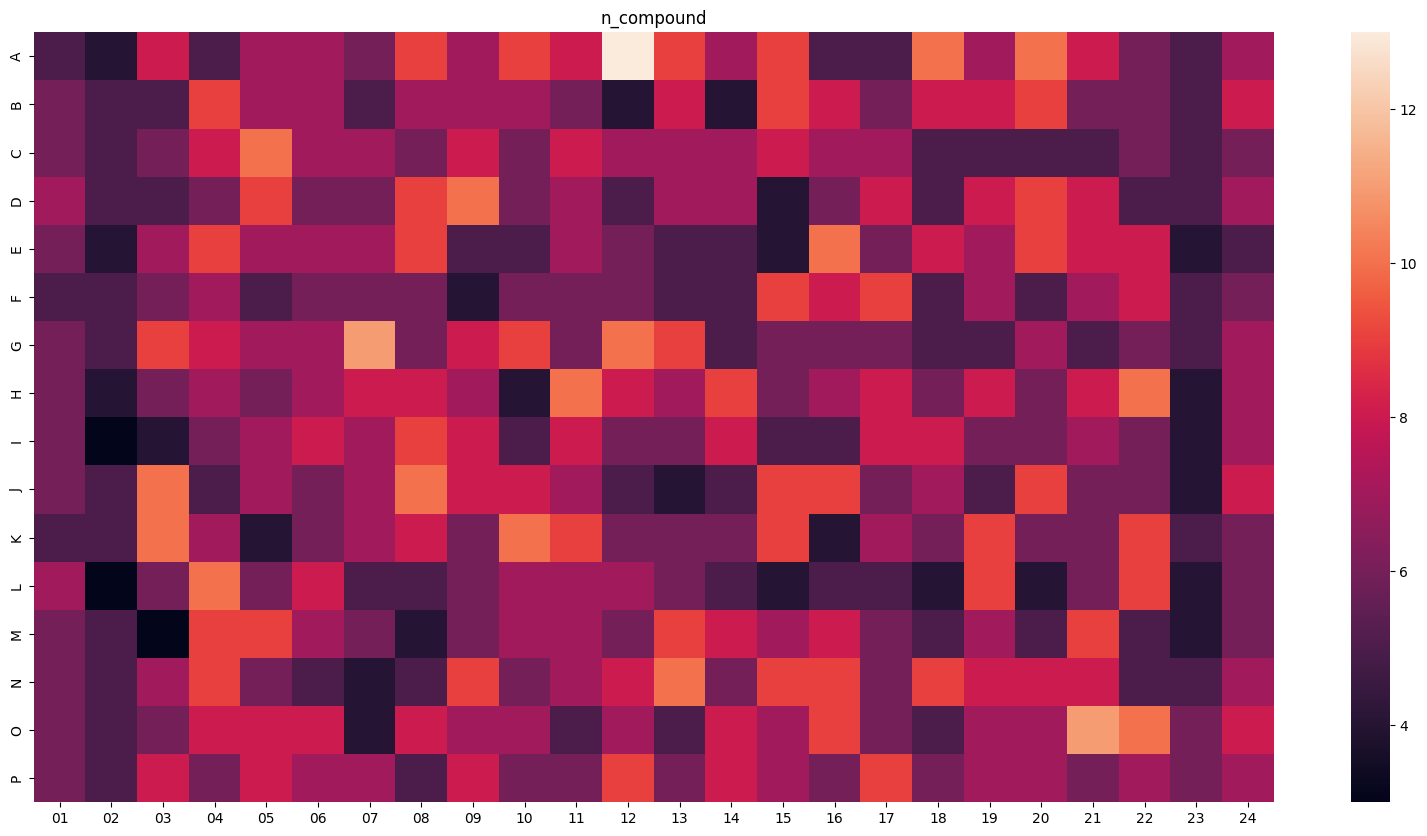

In [12]:
def show_distribution(filter_merge_table):
    info_per_source = (filter_merge_table.group_by("Metadata_Source")
                         .agg(
                             pl.col("Metadata_JCP2022").n_unique().alias("n_compound"),
                             pl.col("Metadata_JCP2022").count().alias("n_sample"))
                       .sort(by=pl.col("Metadata_Source").str.extract("\D+_(\d+)").cast(pl.Int16)))
     
    info_per_micro = (filter_merge_table.group_by("Micro_id")
                         .agg(
                             pl.col("Metadata_JCP2022").n_unique().alias("n_compound"),
                             pl.col("Metadata_JCP2022").count().alias("n_sample"))
                       .sort(by="Micro_id"))
    

    info_per_well = (filter_merge_table.group_by("Metadata_Well")
                     .agg(
                         pl.col("Metadata_JCP2022").n_unique().alias("n_compound"),
                         pl.col("Metadata_JCP2022").count().alias("n_sample"))
                   .sort(by="Metadata_Well").select(
                       pl.col("Metadata_Well").str.extract("(\D+)").alias("Well_letter"),
                       pl.col("Metadata_Well").str.extract("\D+(\d+)").alias("Well_numb"),
                       pl.col("n_compound", "n_sample")))

    
    fig, axes = plt.subplots(2,2, figsize=(20, 10))
    info_per_group = [info_per_source, info_per_micro]
    group = ["Metadata_Source", "Micro_id"]
    info = ["n_sample", "n_compound"]
    for i in range(2):
        for j in range(2):
            sns.barplot(info_per_group[j],
                       x=group[j],
                       y=info[i],
                       ax=axes[i][j])
            axes[i][j].tick_params(axis='x', rotation=90)


    sample_well_map = info_per_well.pivot(index="Well_letter",
                                    columns="Well_numb",
                                    values="n_sample")
    compound_well_map = info_per_well.pivot(index="Well_letter",
                                    columns="Well_numb",
                                    values="n_compound")
    
    
    fig2, ax2 = plt.subplots(1, figsize=(20,10))
    sns.heatmap(sample_well_map.select(pl.all().exclude("Well_letter")),
                ax=ax2)
    ax2.set_xticklabels(sample_well_map.columns[1:])
    ax2.set_yticklabels(sample_well_map.select(pl.col("Well_letter")).to_numpy().reshape(-1))
    ax2.set_title("n_sample")

    
    fig3, ax3 = plt.subplots(1, figsize=(20,10))
    sns.heatmap(compound_well_map.select(pl.all().exclude("Well_letter")),
                ax=ax3)
    ax3.set_xticklabels(compound_well_map.columns[1:])
    ax3.set_yticklabels(compound_well_map.select(pl.col("Well_letter")).to_numpy().reshape(-1))
    ax3.set_title("n_compound")
show_distribution(merge_table)

In [13]:
merge_table.group_by("Metadata_Source").agg(pl.col("Metadata_JCP2022").n_unique())

Metadata_Source,Metadata_JCP2022
str,u32
"""source_4""",302
"""source_3""",302
"""source_2""",301
"""source_5""",302
"""source_6""",302
"""source_11""",302
"""source_7""",302
"""source_10""",302
"""source_8""",302


* The goal is to downsample each source so it is more alike to source 4. But we cannot remove sample randomly without risking removing some interesting compound of target2. Indeed in target2 there are poscon or negcon that might have been overused in some sources so we should downsampling from those negcon and poscon. There should be easy to identify as they should have been overused.
* There is one compound that has not been used in all sources so let's remove it as well. 

# 3) Table Filtering
### a) Removal of the compounds not in all sources.

In [14]:
merge_table = (merge_table.filter(
    pl.col("Metadata_JCP2022").is_in((merge_table.group_by("Metadata_JCP2022")
                                      .agg(pl.col("Metadata_Source").n_unique()).
                                      filter(pl.col("Metadata_Source") < 9)
                                      .select("Metadata_JCP2022")).to_series()) == False))

### b) Identification of the compounds to downsample. 

In [15]:
compounds_info = (merge_table.group_by("Metadata_JCP2022")
                  .agg(pl.col("Metadata_InChIKey").count().alias("Sample_count"),
                       pl.col("Metadata_Source", "Metadata_Well", "Micro_id")
                       .n_unique().name.prefix("Unique_"))
                       )

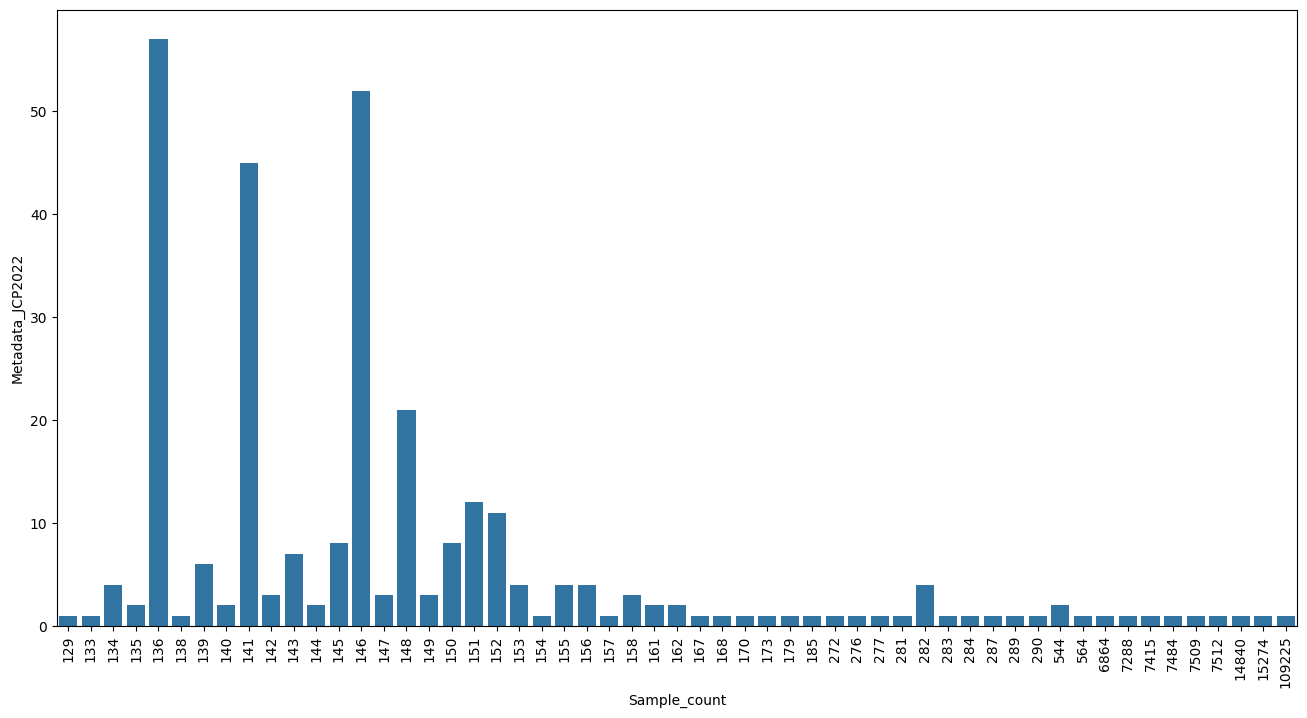

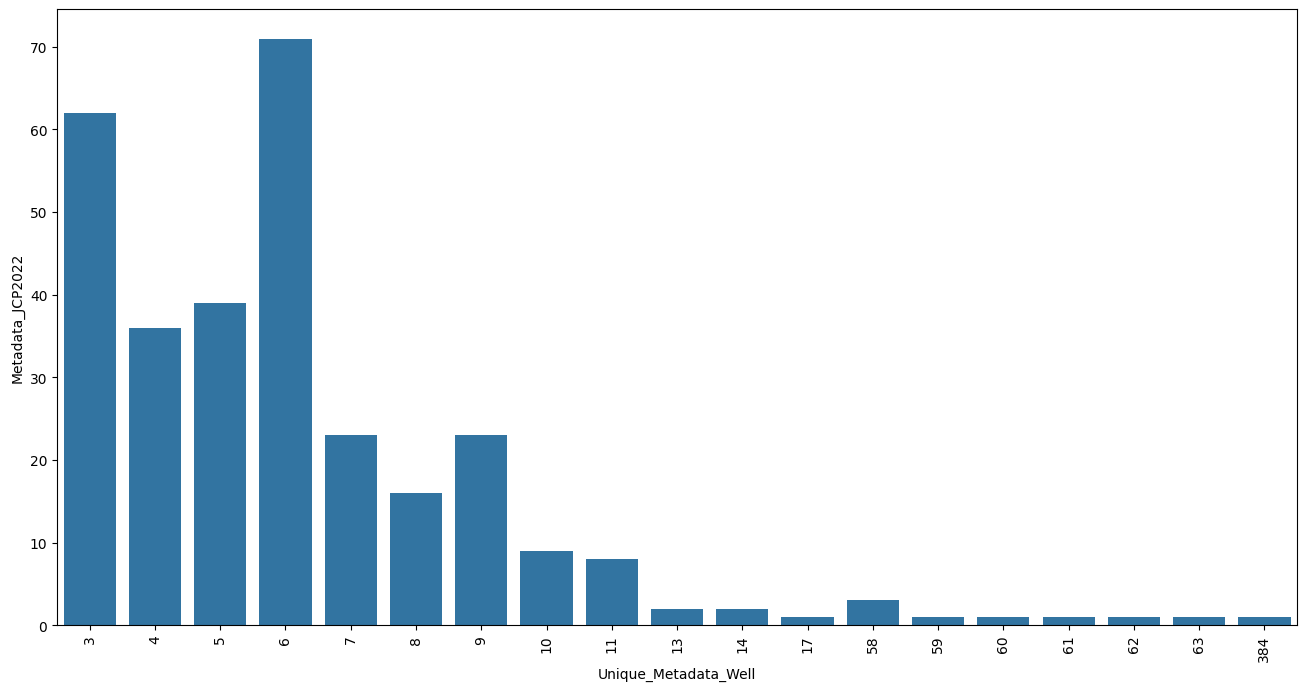

In [16]:
fig, ax1 = plt.subplots(1, figsize=(16,8))

df = (compounds_info.group_by("Sample_count")
             .agg(pl.col("Metadata_JCP2022").n_unique()).sort(by="Sample_count"))

sns.barplot(df,
            x="Sample_count",
            y="Metadata_JCP2022",
            ax=ax1)
ax1.tick_params(axis='x', rotation=90)

fig, ax2 = plt.subplots(1, figsize=(16,8))

df2 = (compounds_info.group_by("Unique_Metadata_Well")
             .agg(pl.col("Metadata_JCP2022").n_unique()).sort(by="Unique_Metadata_Well"))

sns.barplot(df2,
            x="Unique_Metadata_Well",
            y="Metadata_JCP2022",
            ax=ax2)
ax2.tick_params(axis='x', rotation=90)

2 group can be identified looking at the count of sample per compounds. 
* Compounds with a usage < 200 samples.
* Compounds with a usage between 200 and 300 samples.
* Compounds with a usage between 500 and 600 samples.
* Compounds with a usage exceptionnally high, more than 6000 usage: this is usually control. 

Each category should be down sample seperately. 

### c) Down Sampling of the control

In [17]:
seed = 42

In [18]:
controle_name = (compounds_info
.filter(pl.col("Sample_count") > 600).select("Metadata_JCP2022")).to_series()

trt_name = (compounds_info
.filter(pl.col("Sample_count") < 200).select("Metadata_JCP2022")).to_series()

between1_name = (compounds_info
.filter(pl.col("Sample_count").is_between(200, 300)).select("Metadata_JCP2022")).to_series()

between2_name = (compounds_info
.filter(pl.col("Sample_count").is_between(300, 600)).select("Metadata_JCP2022")).to_series()

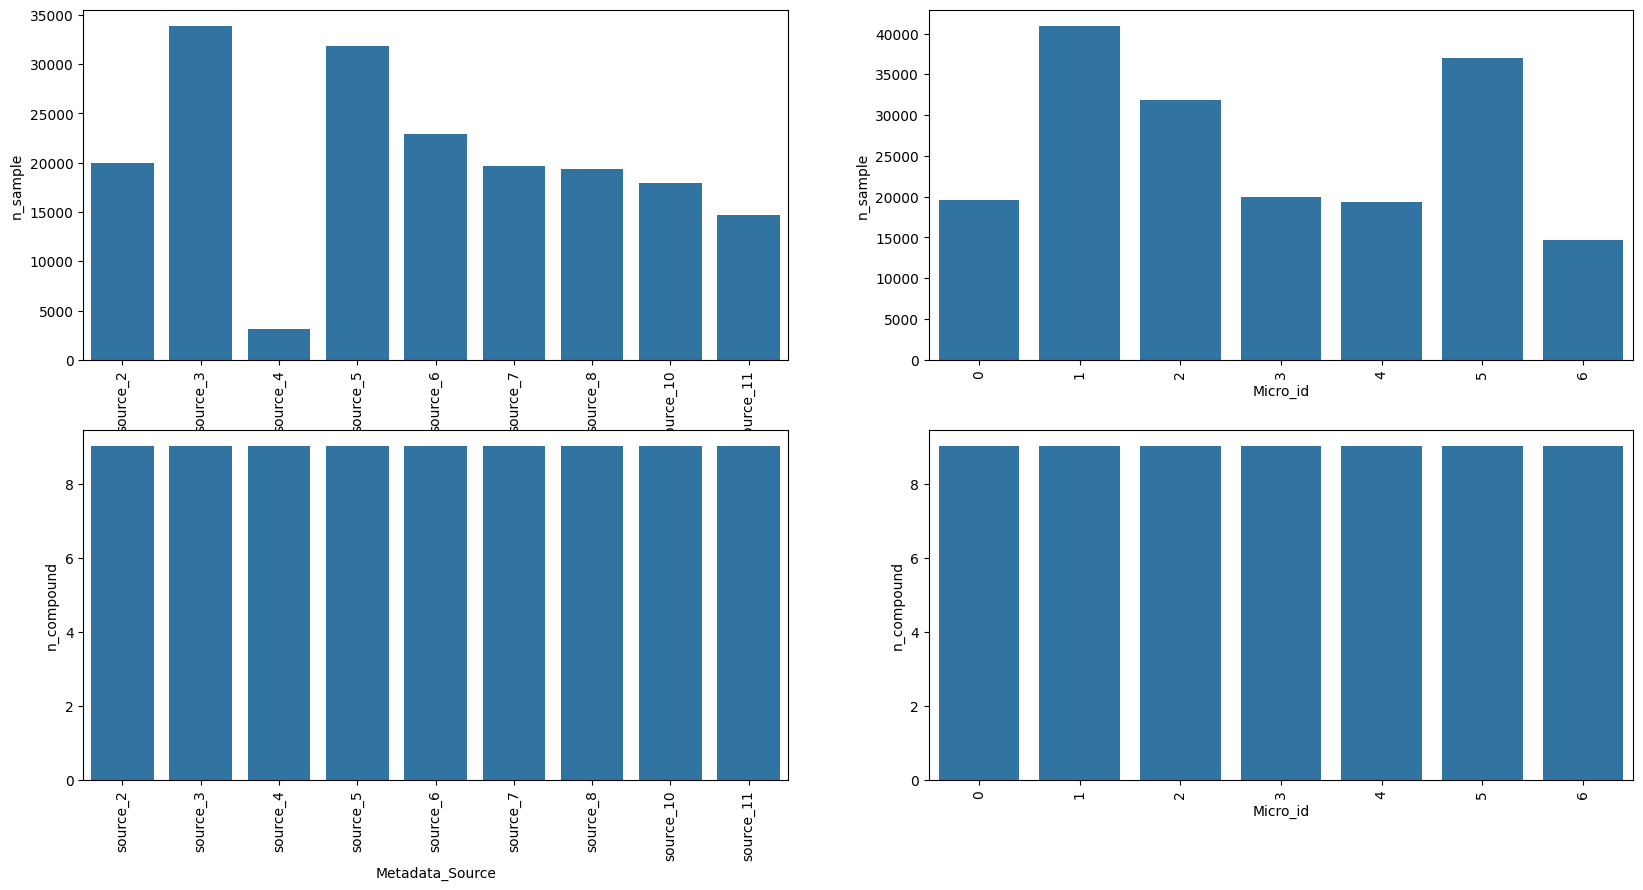

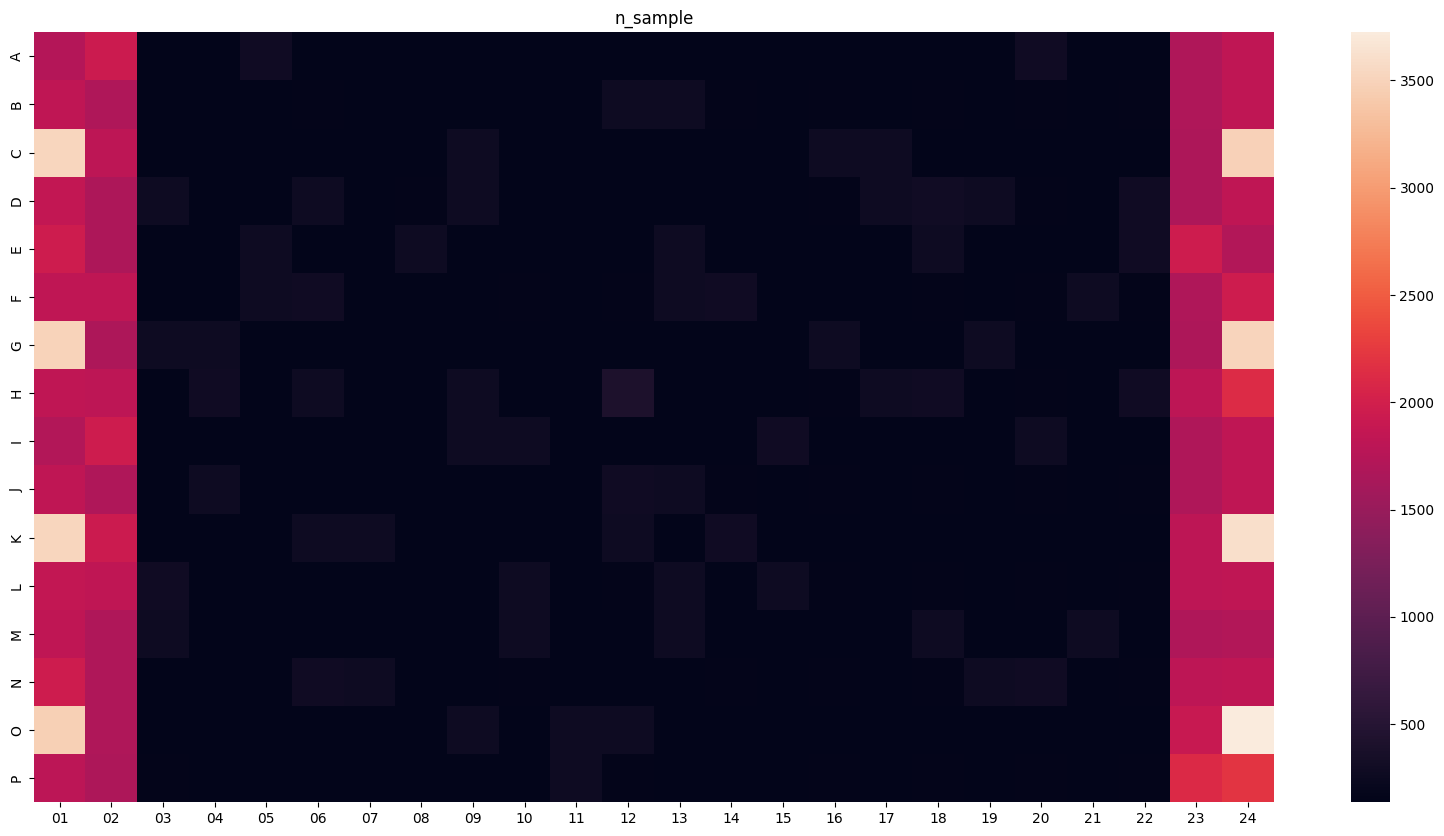

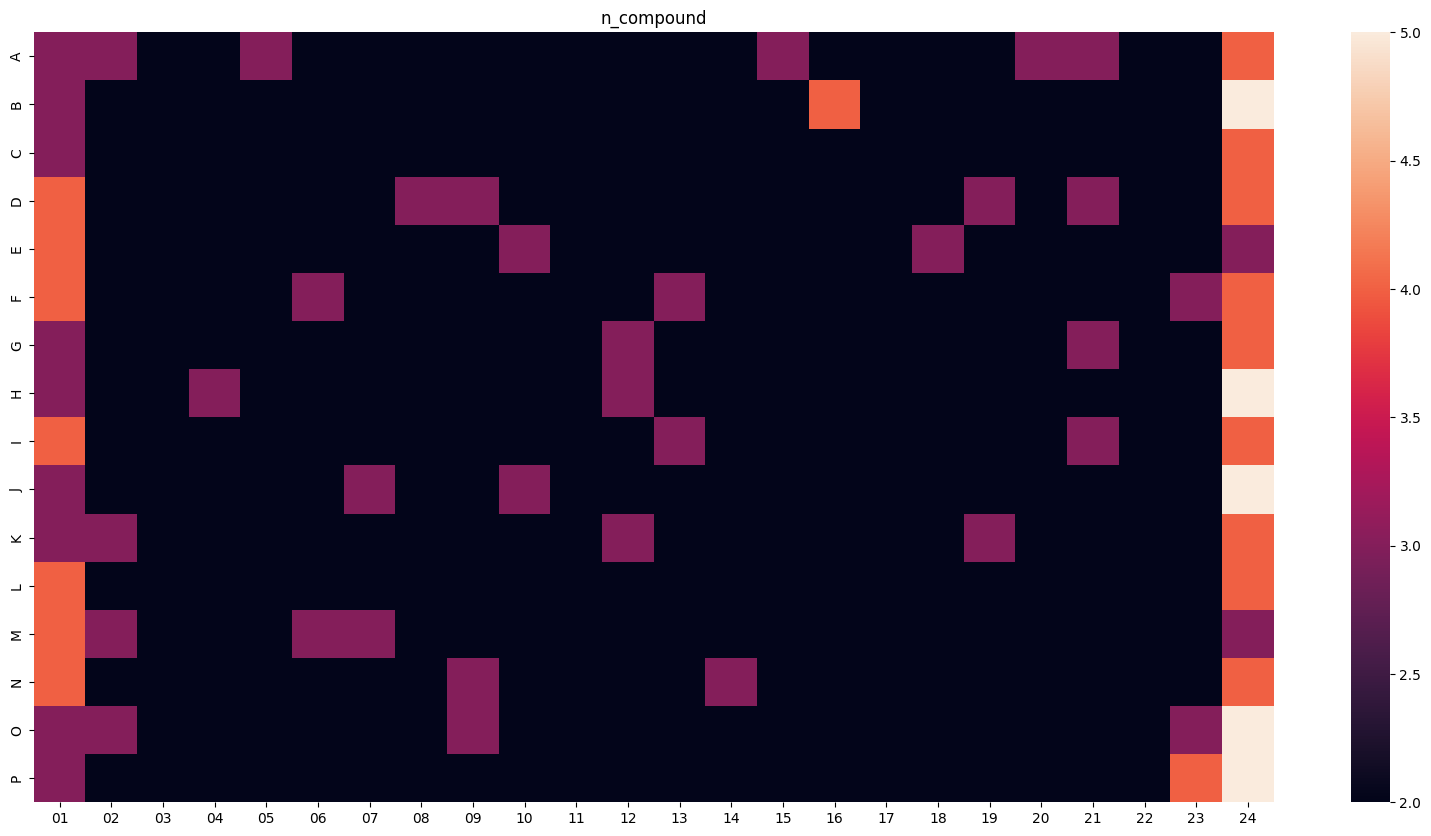

In [19]:
# First see how to downsample
show_distribution(merge_table.filter(
    pl.col("Metadata_JCP2022").is_in(
        controle_name)))

In [20]:
#For every source excpet for the source 4, down sampling to only 2800 samples 
merge_table_control = (merge_table.filter(
    pl.col("Metadata_JCP2022").is_in(controle_name))
.filter(
    pl.col("Metadata_Source").str.contains("_4$") != True)
.sort(by=["Metadata_Source", "Metadata_JCP2022", "Metadata_Plate", "Metadata_Well", "Metadata_Batch"]))

merge_table_control_keep = (merge_table_control.group_by("Metadata_Source")
     .agg(pl.struct(pl.col("Metadata_JCP2022", "Metadata_Plate", "Metadata_Well", "Metadata_Batch"))
          .sort()
          .sample(2800, seed=seed))
     .sort(by="Metadata_Source")
    .explode("Metadata_JCP2022")
    .unnest("Metadata_JCP2022"))

In [21]:
merge_table_control = (merge_table_control.join(merge_table_control_keep,
                         on=["Metadata_Source","Metadata_JCP2022", "Metadata_Plate", 
                             "Metadata_Well", "Metadata_Batch"],
                         how="inner")
                       .unique()
                       .join((merge_table.filter(
                           pl.col("Metadata_JCP2022").is_in(controle_name))
                              .filter(
                                  pl.col("Metadata_Source").str.contains("_4$"))),
                             on=merge_table.columns,
                             how="outer")).unique()

### d) Down Sampling of the between1 and between2 category

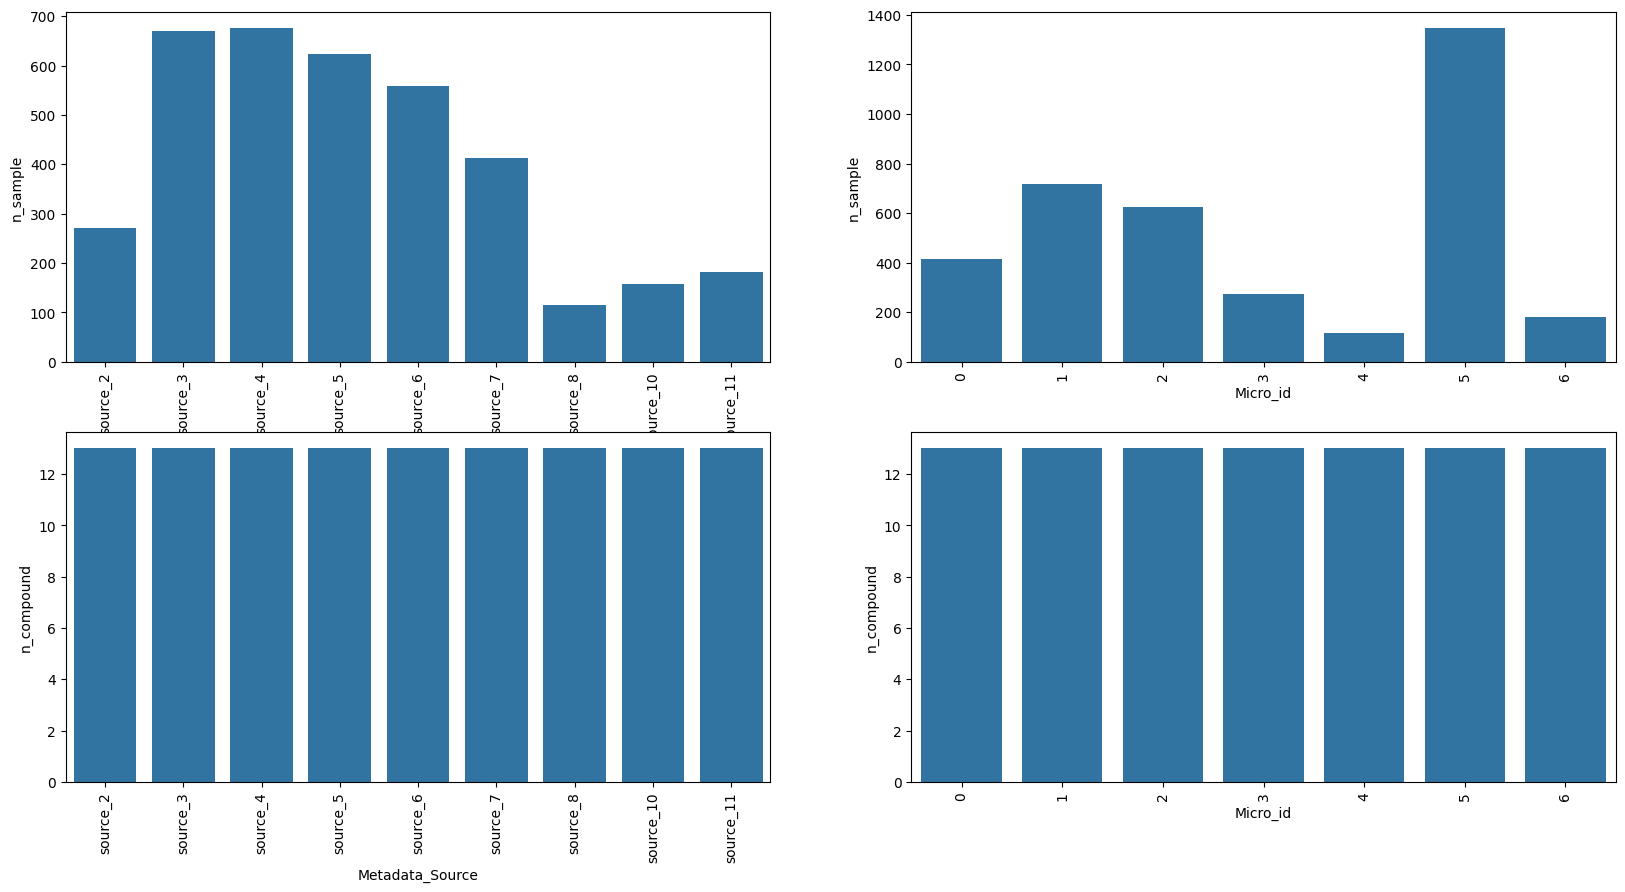

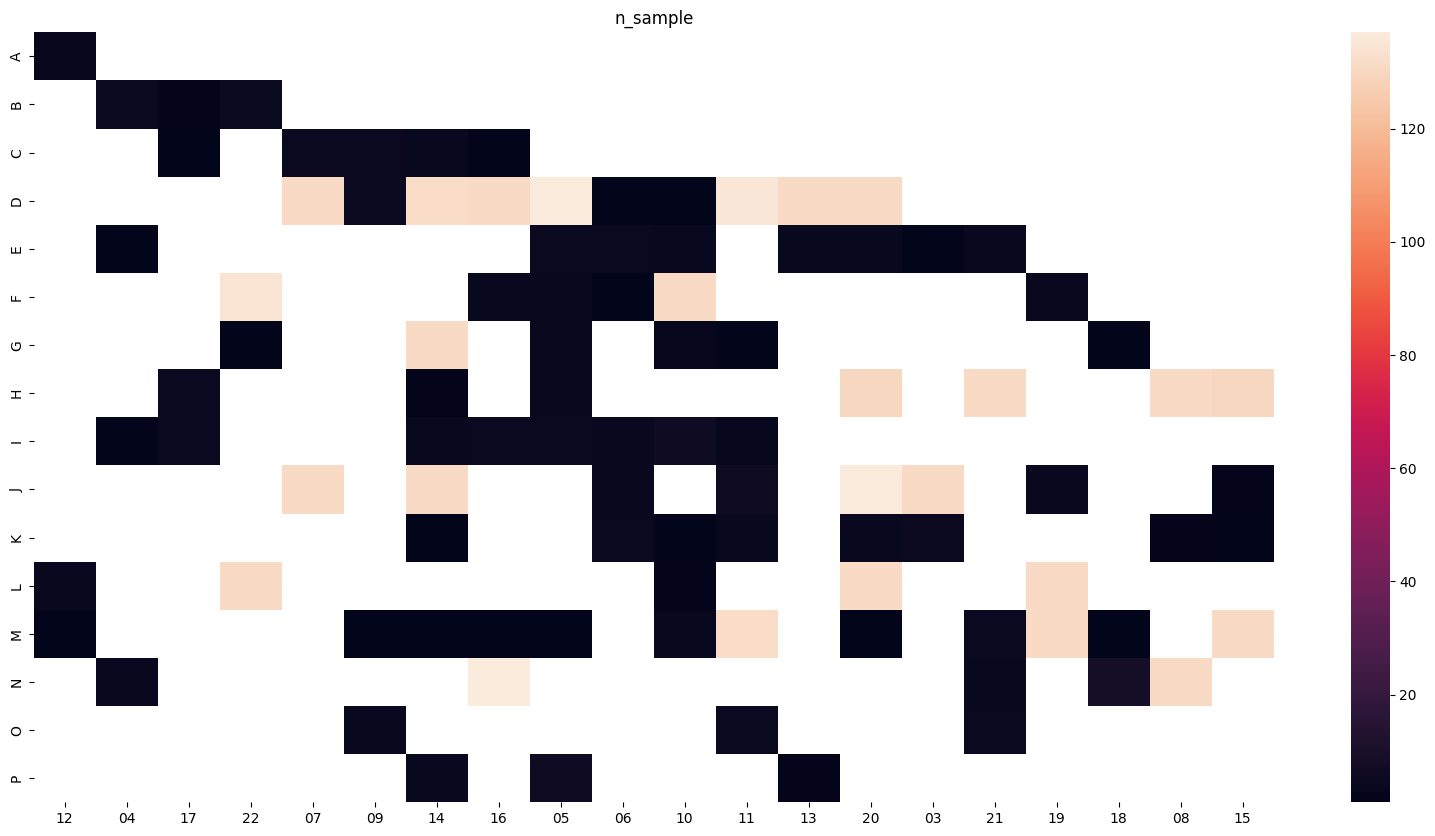

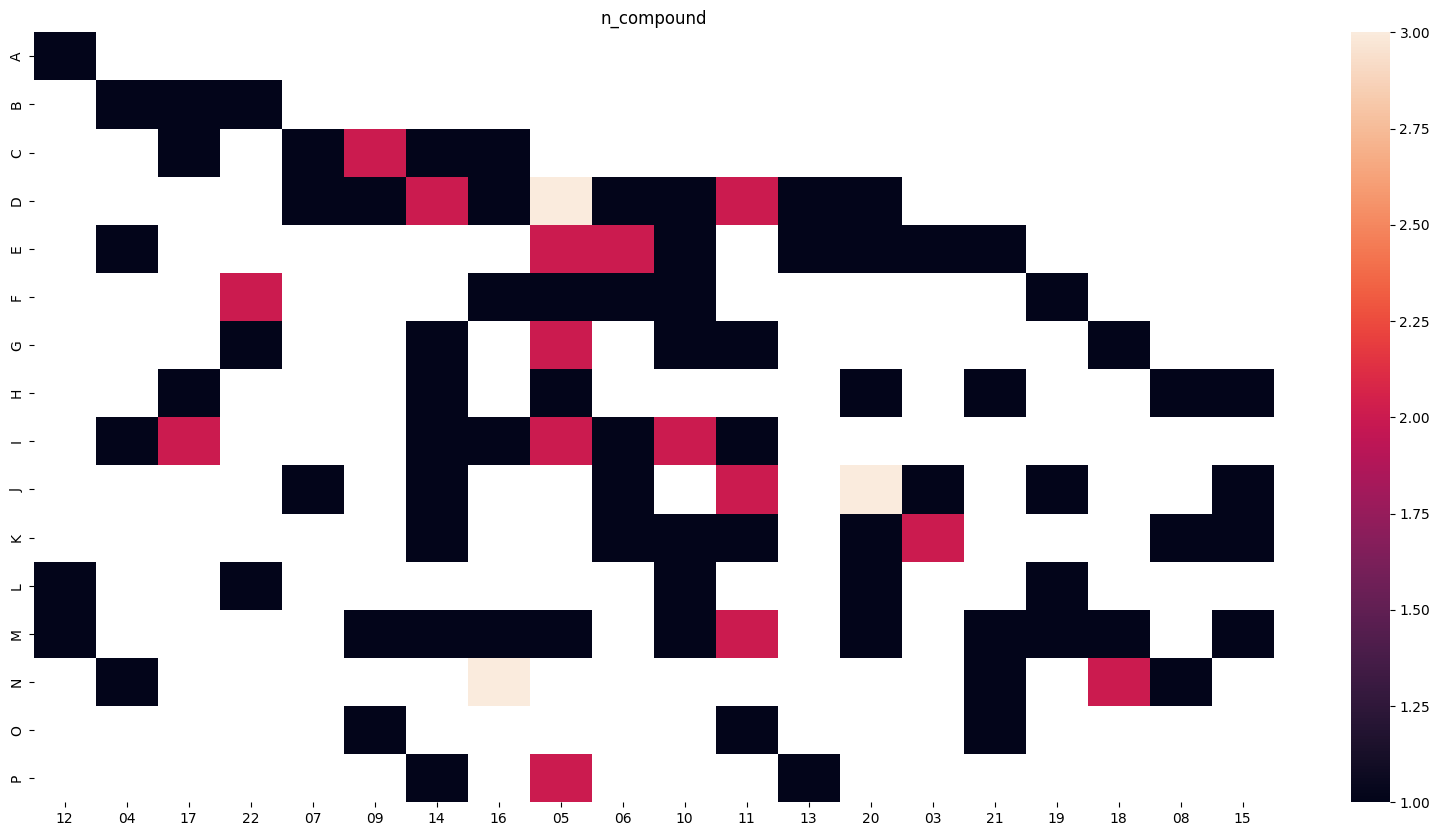

In [22]:
show_distribution(merge_table.filter(pl.col("Metadata_JCP2022").is_in(between1_name)))

In [23]:
merge_table_between1 = (merge_table.filter(
    pl.col("Metadata_JCP2022").is_in(between1_name))
.sort(by=["Metadata_Source", "Metadata_JCP2022", "Metadata_Plate", "Metadata_Well", "Metadata_Batch"]))

merge_table_between_keep1 = (merge_table_between1.group_by("Metadata_Source")
     .agg(pl.struct(pl.col("Metadata_JCP2022", "Metadata_Plate", "Metadata_Well", "Metadata_Batch"))
          .sort()
          .sample(90, seed=seed))
     .sort(by="Metadata_Source")
    .explode("Metadata_JCP2022")
    .unnest("Metadata_JCP2022"))

In [24]:
merge_table_between1 = (merge_table_between1.join(merge_table_between_keep1,
                         on=["Metadata_Source","Metadata_JCP2022", "Metadata_Plate", 
                             "Metadata_Well", "Metadata_Batch"],
                         how="inner"))

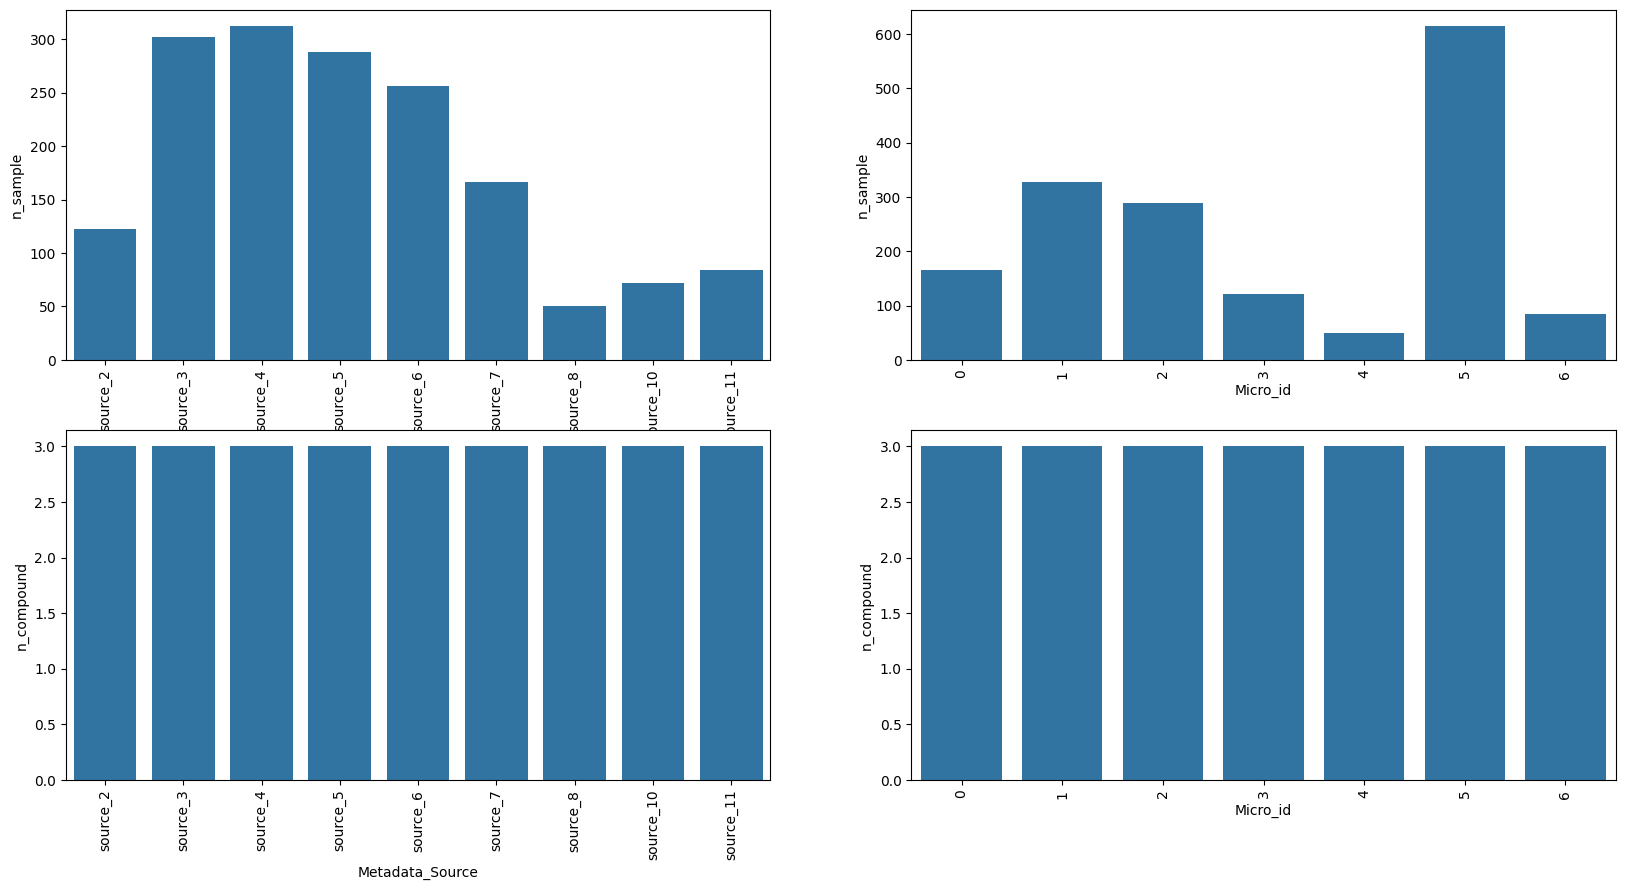

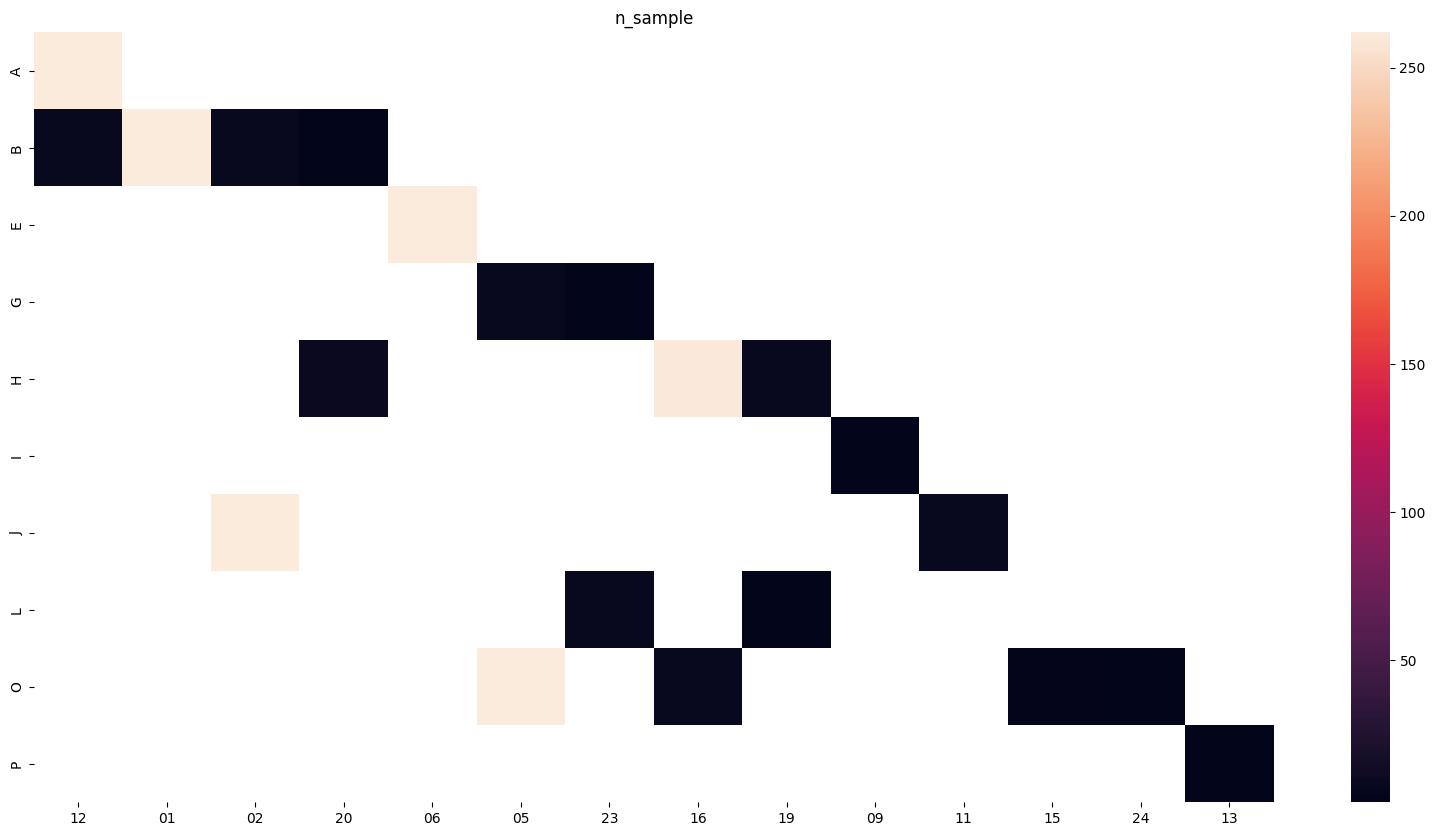

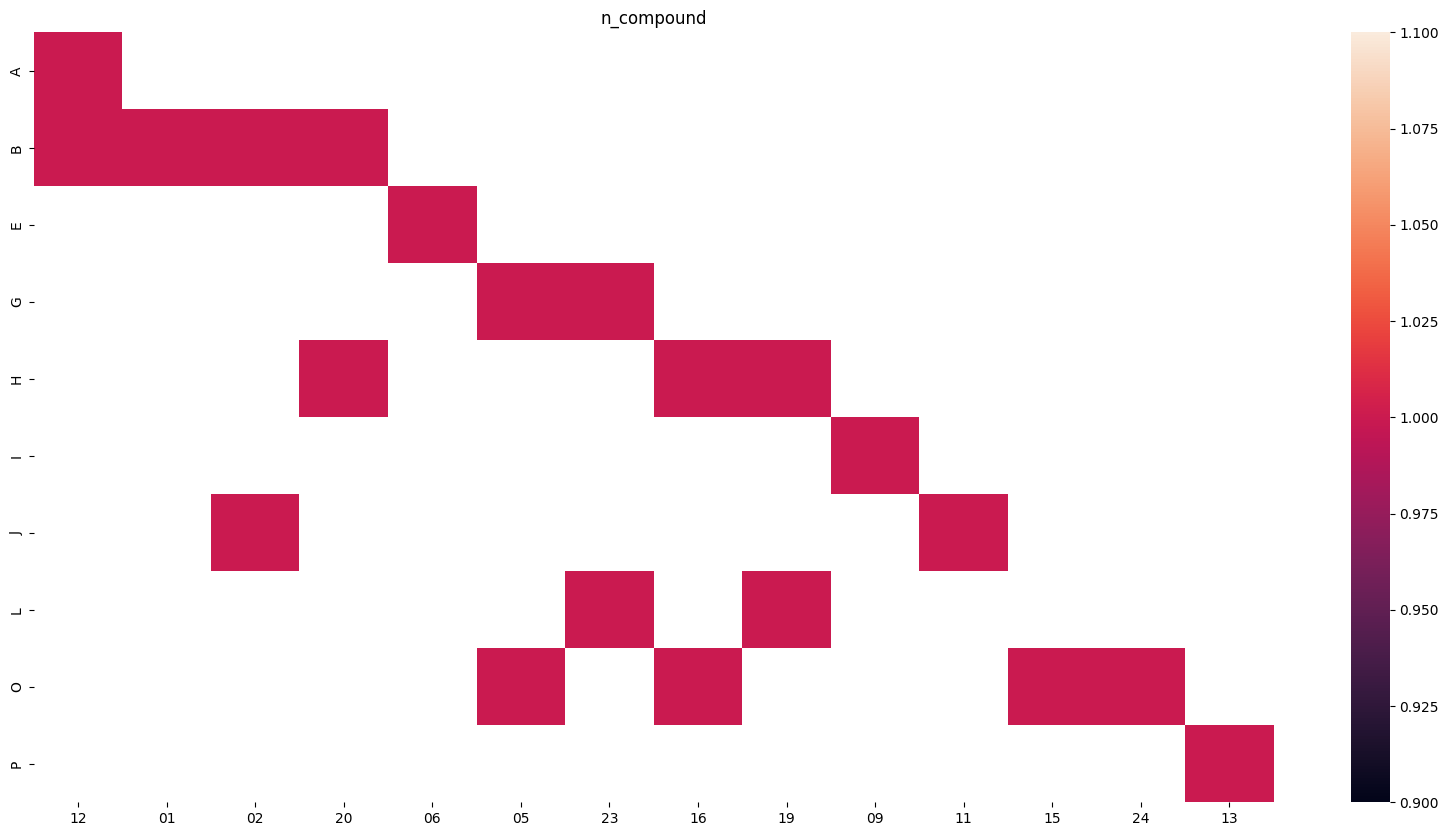

In [25]:
show_distribution(merge_table.filter(pl.col("Metadata_JCP2022").is_in(between2_name)))

In [26]:
merge_table_between2 = (merge_table.filter(
    pl.col("Metadata_JCP2022").is_in(between2_name))
.sort(by=["Metadata_Source", "Metadata_JCP2022", "Metadata_Plate", "Metadata_Well", "Metadata_Batch"]))

merge_table_between_keep2 = (merge_table_between2.group_by("Metadata_Source")
     .agg(pl.struct(pl.col("Metadata_JCP2022", "Metadata_Plate", "Metadata_Well", "Metadata_Batch"))
          .sort()
          .sample(14, seed=seed))
     .sort(by="Metadata_Source")
    .explode("Metadata_JCP2022")
    .unnest("Metadata_JCP2022"))

In [27]:
merge_table_between2 = (merge_table_between2.join(merge_table_between_keep2,
                         on=["Metadata_Source","Metadata_JCP2022", "Metadata_Plate", 
                             "Metadata_Well", "Metadata_Batch"],
                         how="inner"))

### e) Down Sampling of treatment

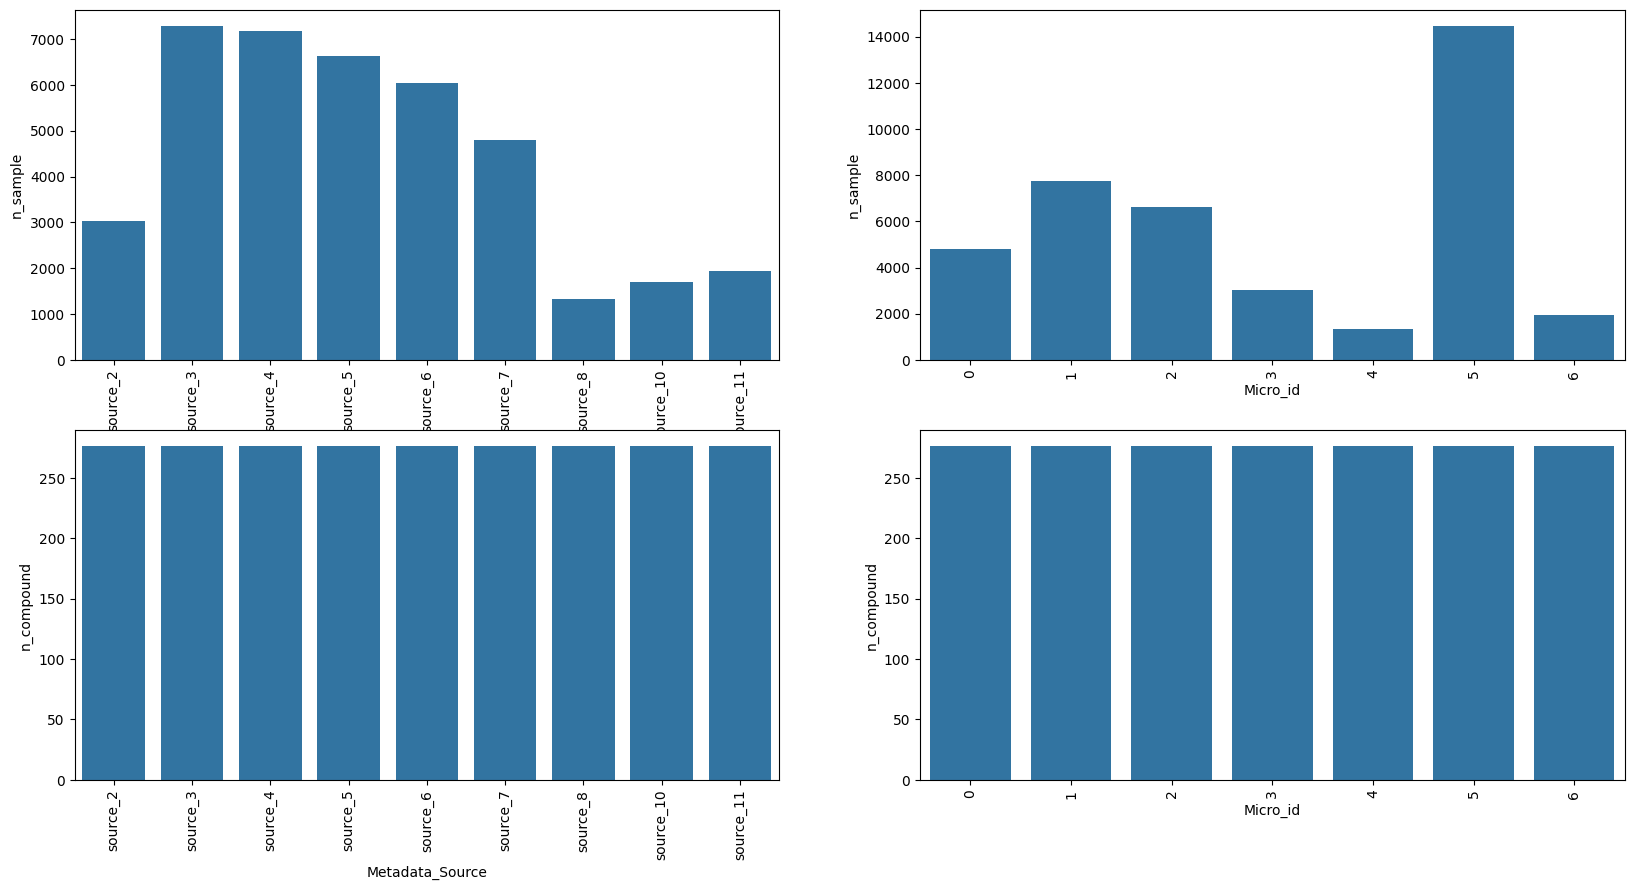

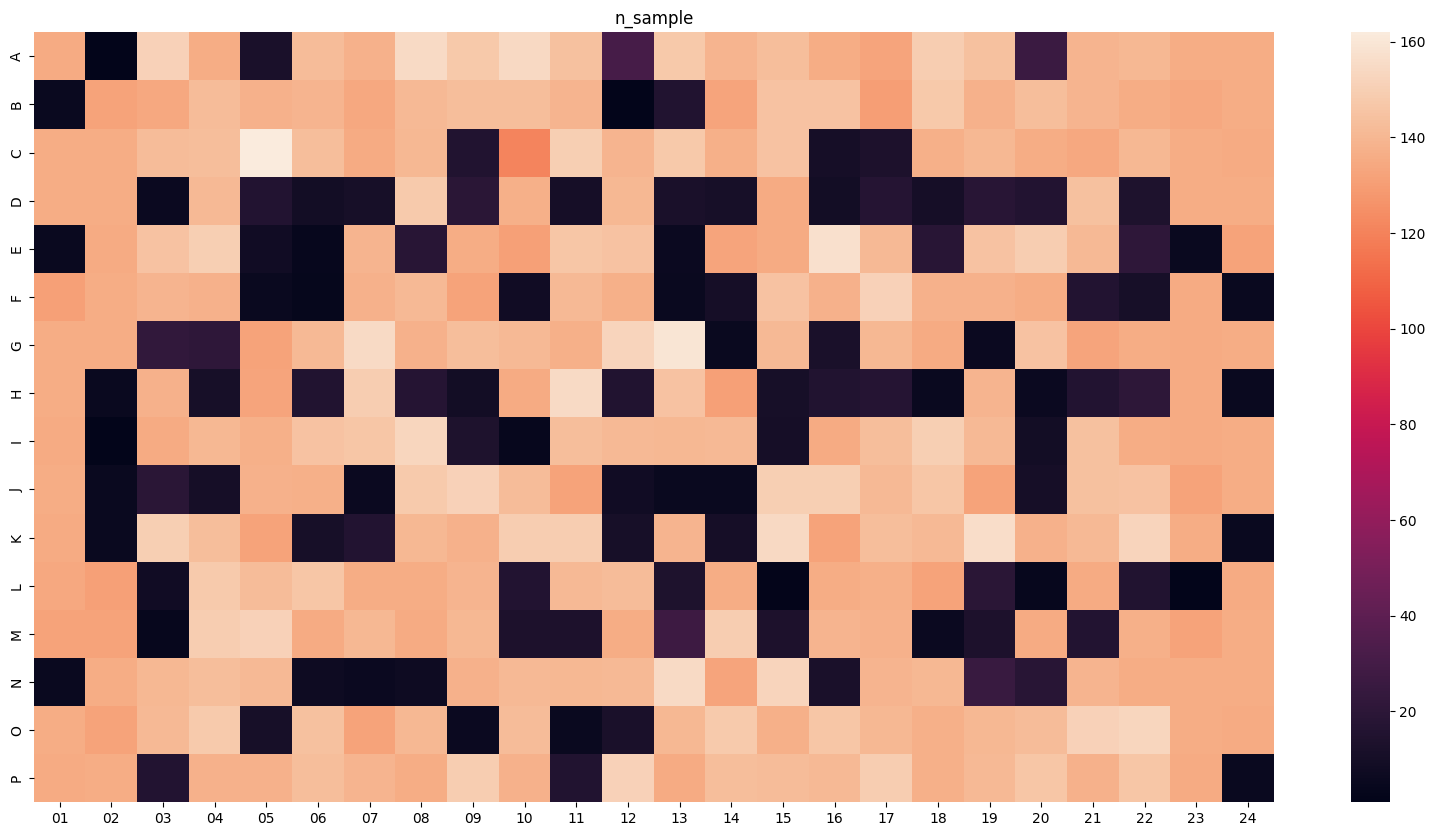

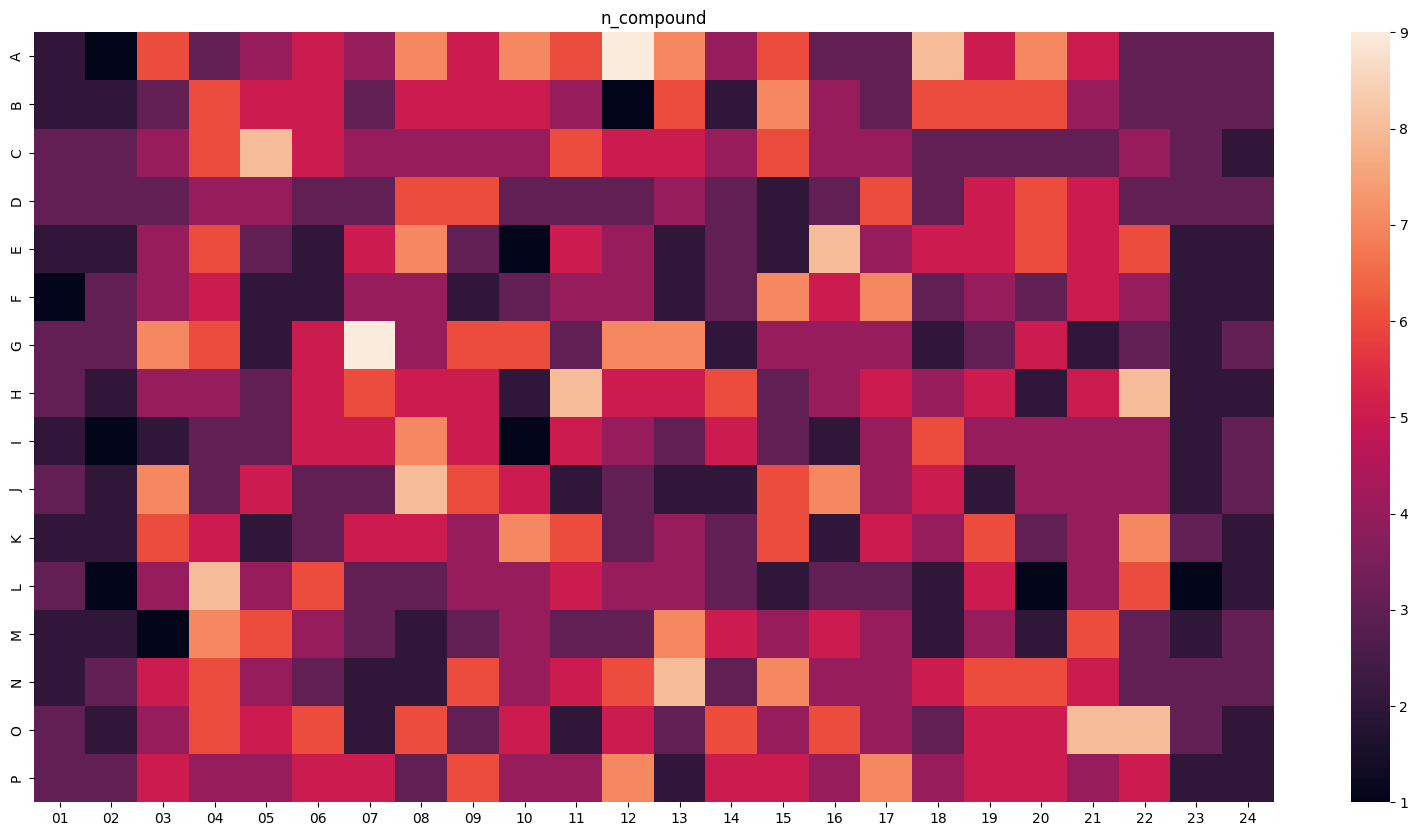

In [28]:
show_distribution(merge_table.filter(pl.col("Metadata_JCP2022").is_in(trt_name)))

In [29]:
merge_table_trt = (merge_table.filter(
    pl.col("Metadata_JCP2022").is_in(trt_name))
.filter(
    pl.col("Metadata_Source").str.contains("_8$") != True)
.sort(by=["Metadata_Source", "Metadata_JCP2022", "Metadata_Plate", "Metadata_Well", "Metadata_Batch"]))

merge_table_trt_keep = (merge_table_trt.group_by("Metadata_Source")
     .agg(pl.struct(pl.col("Metadata_JCP2022", "Metadata_Plate", "Metadata_Well", "Metadata_Batch"))
          .sort()
          .sample(1350, seed=seed))
     .sort(by="Metadata_Source")
    .explode("Metadata_JCP2022")
    .unnest("Metadata_JCP2022"))

In [30]:
merge_table_trt = (merge_table_trt.join(merge_table_trt_keep,
                         on=["Metadata_Source","Metadata_JCP2022", "Metadata_Plate", 
                             "Metadata_Well", "Metadata_Batch"],
                         how="inner")
                       .join((merge_table.filter(
                           pl.col("Metadata_JCP2022").is_in(trt_name))
                              .filter(
                                  pl.col("Metadata_Source").str.contains("_8$"))),
                             on=merge_table.columns,
                             how="outer")).unique()

### f) merging all group sampled

In [31]:
merge_table_filtered = (merge_table_trt.join(
                        merge_table_between1,
                        on=merge_table_trt.columns,
                        how="outer")
                     .join(merge_table_between2,
                           on=merge_table_trt.columns,
                           how="outer")
                     .join(merge_table_control,
                           on=merge_table_trt.columns,
                           how="outer"))
    

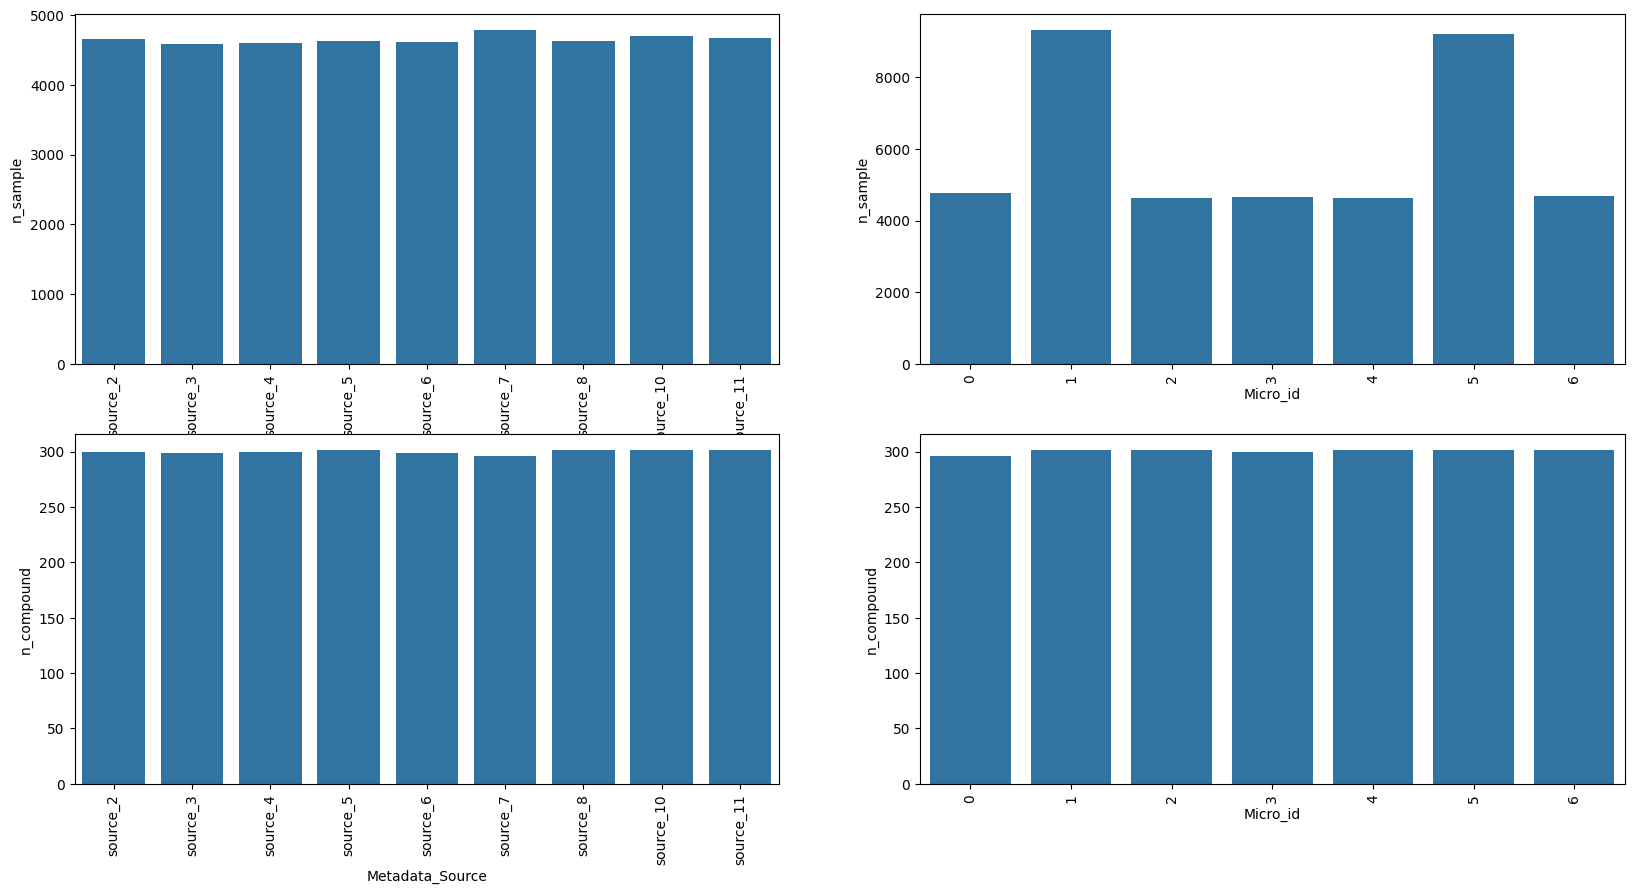

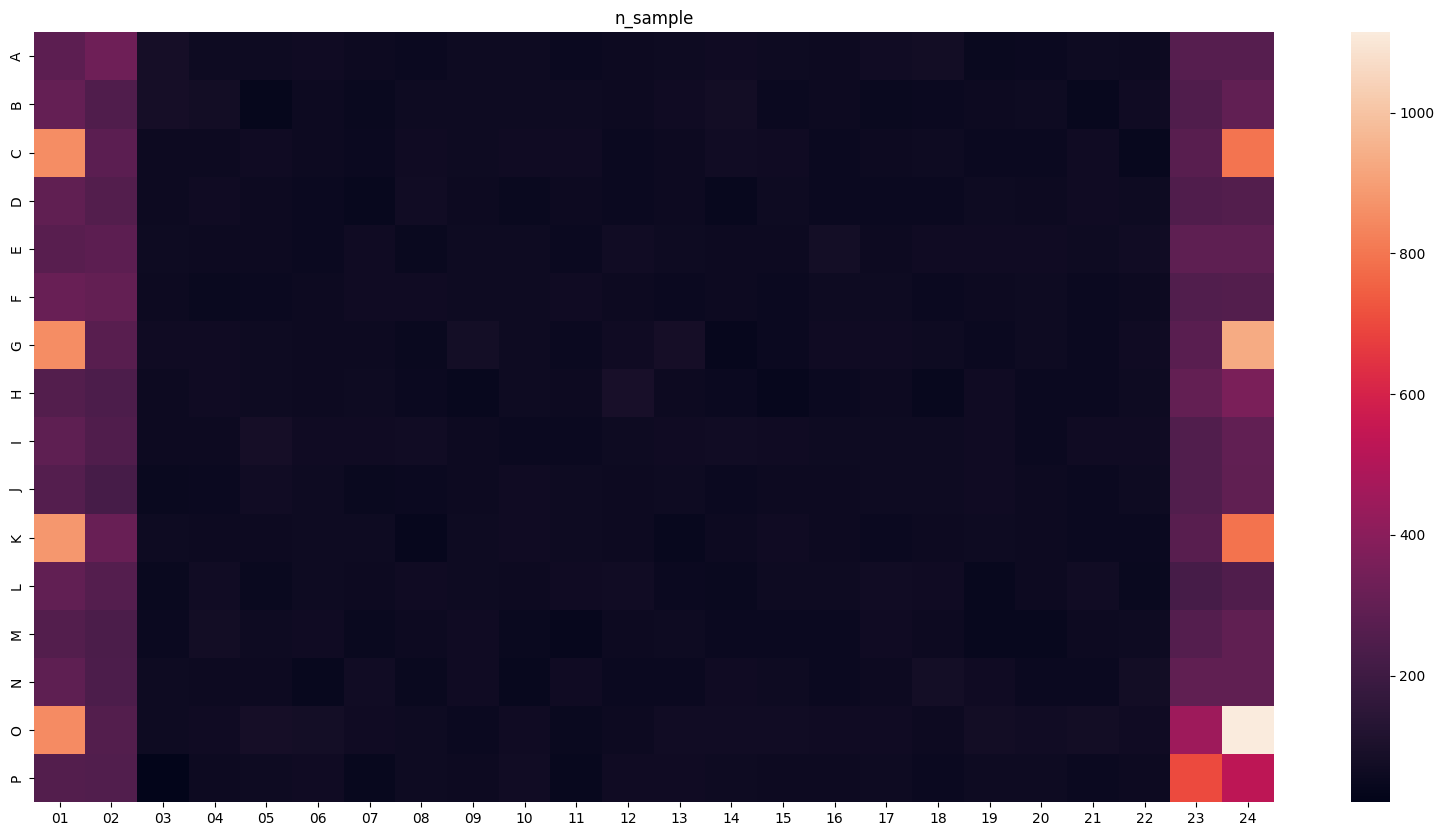

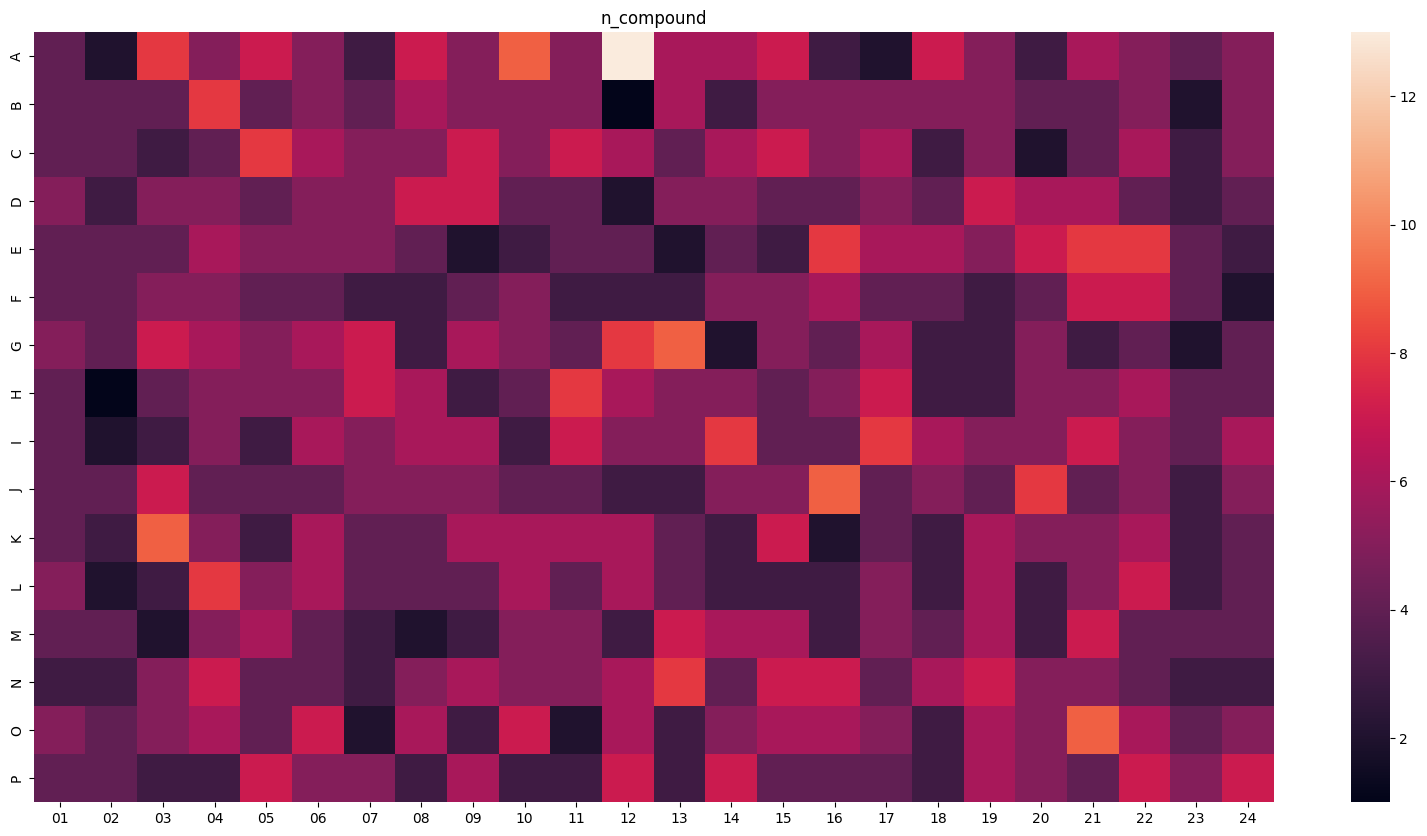

In [32]:
show_distribution(merge_table_filtered)

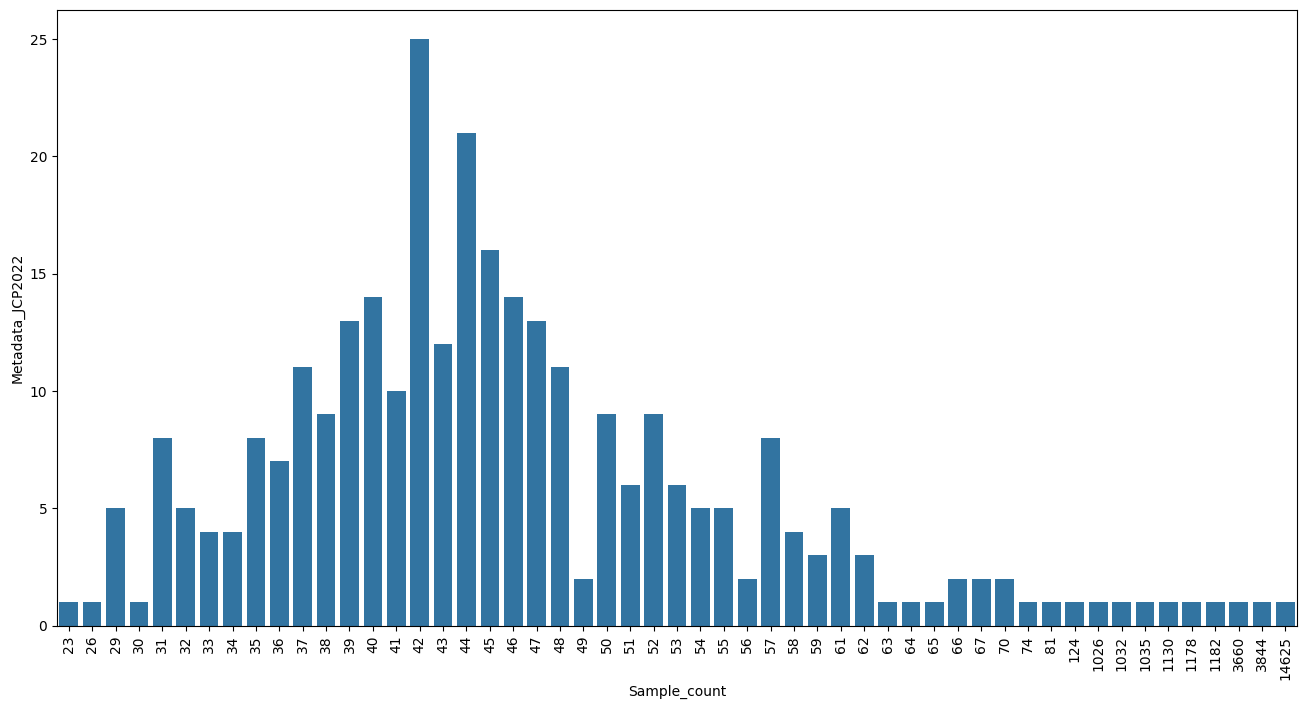

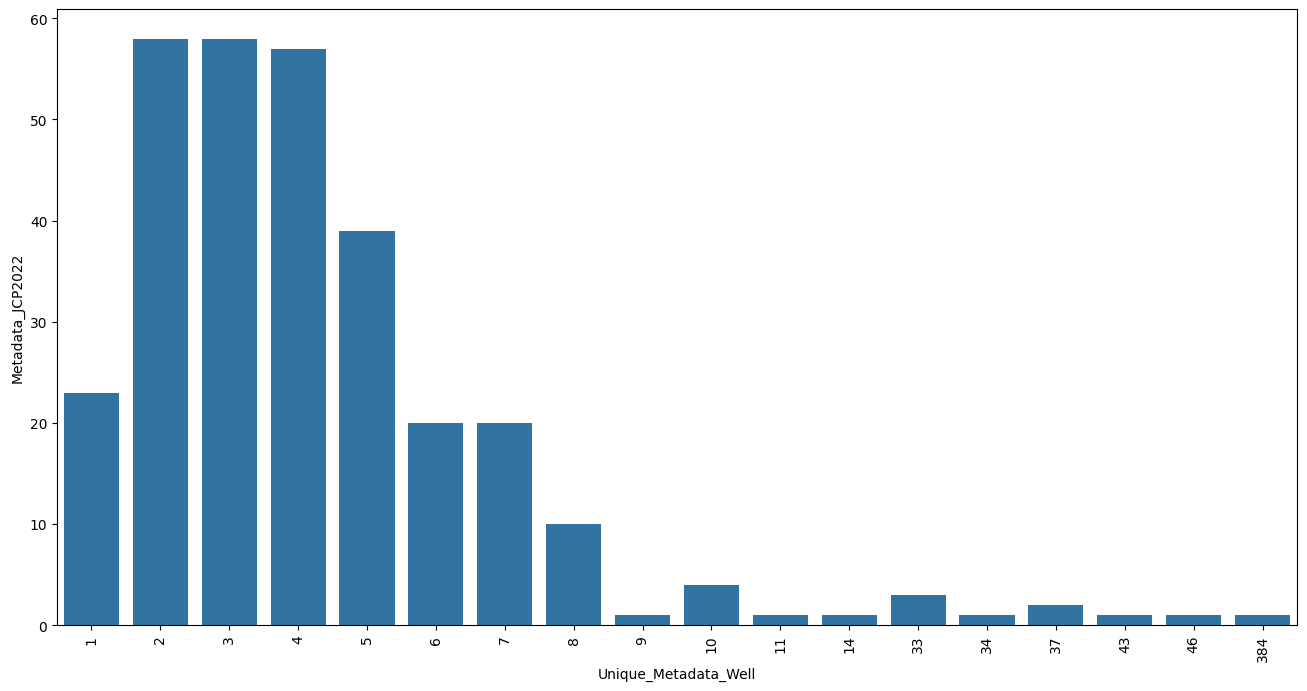

In [33]:
compounds_info_filtered = (merge_table_filtered.group_by("Metadata_JCP2022")
                  .agg(pl.col("Metadata_InChIKey").count().alias("Sample_count"),
                       pl.col("Metadata_Source", "Metadata_Well", "Micro_id")
                       .n_unique().name.prefix("Unique_"))
                       )

fig, ax1 = plt.subplots(1, figsize=(16,8))

df_filtered = (compounds_info_filtered.group_by("Sample_count")
             .agg(pl.col("Metadata_JCP2022").n_unique()).sort(by="Sample_count"))

sns.barplot(df_filtered,
            x="Sample_count",
            y="Metadata_JCP2022",
            ax=ax1)
ax1.tick_params(axis='x', rotation=90)

fig, ax2 = plt.subplots(1, figsize=(16,8))

df2_filtered = (compounds_info_filtered.group_by("Unique_Metadata_Well")
             .agg(pl.col("Metadata_JCP2022").n_unique()).sort(by="Unique_Metadata_Well"))

sns.barplot(df2_filtered,
            x="Unique_Metadata_Well",
            y="Metadata_JCP2022",
            ax=ax2)
ax2.tick_params(axis='x', rotation=90)

### g) Let's see if some compounds has disapeared from sources and how to put them back in a meaningful way

#### Count of Sample per source per compound
#### Count of Unique Well per source per compound
Let's compute these metric without considering the control compounds.

Text(0.5, 1.0, 'Count of Unique Well per source per compound')

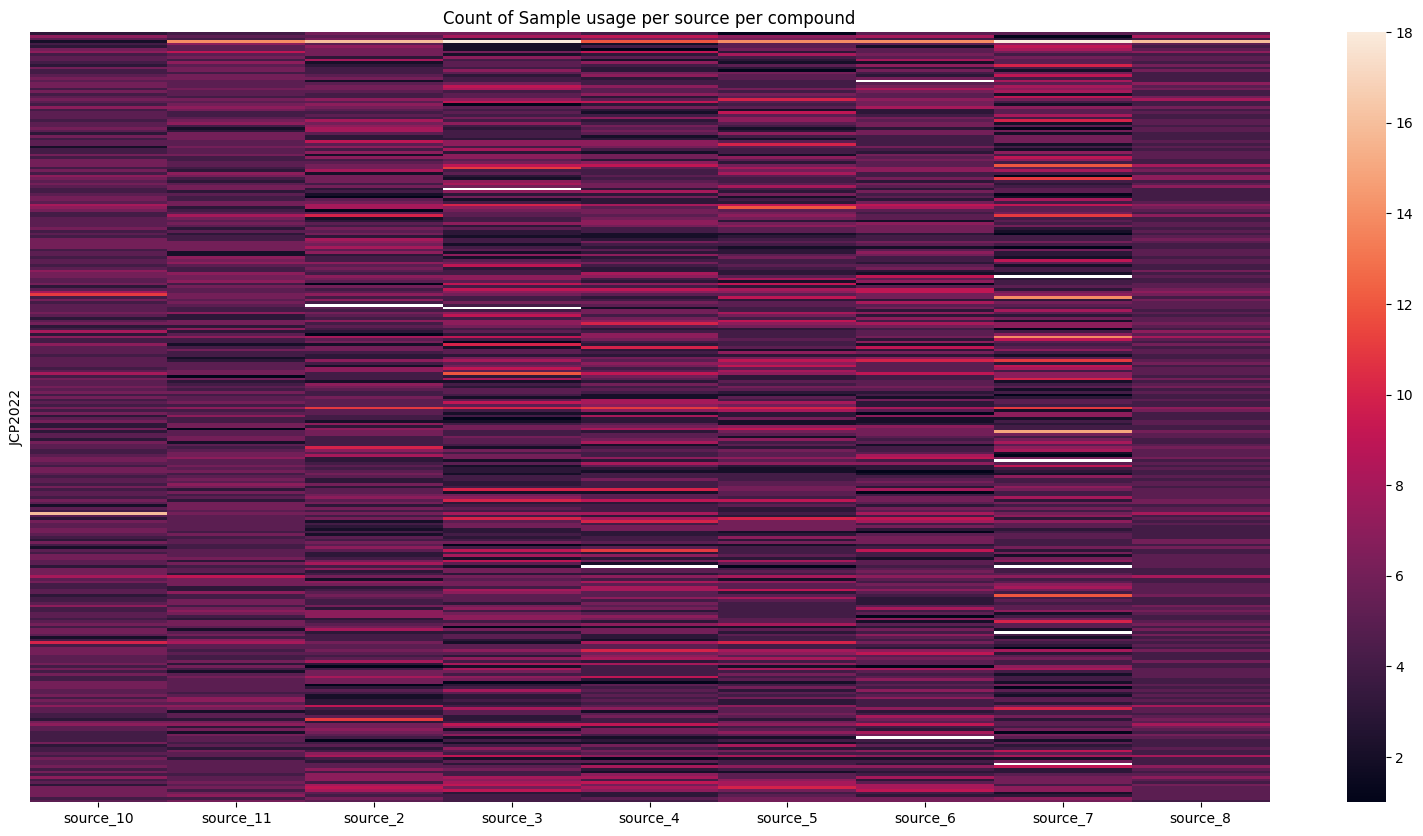

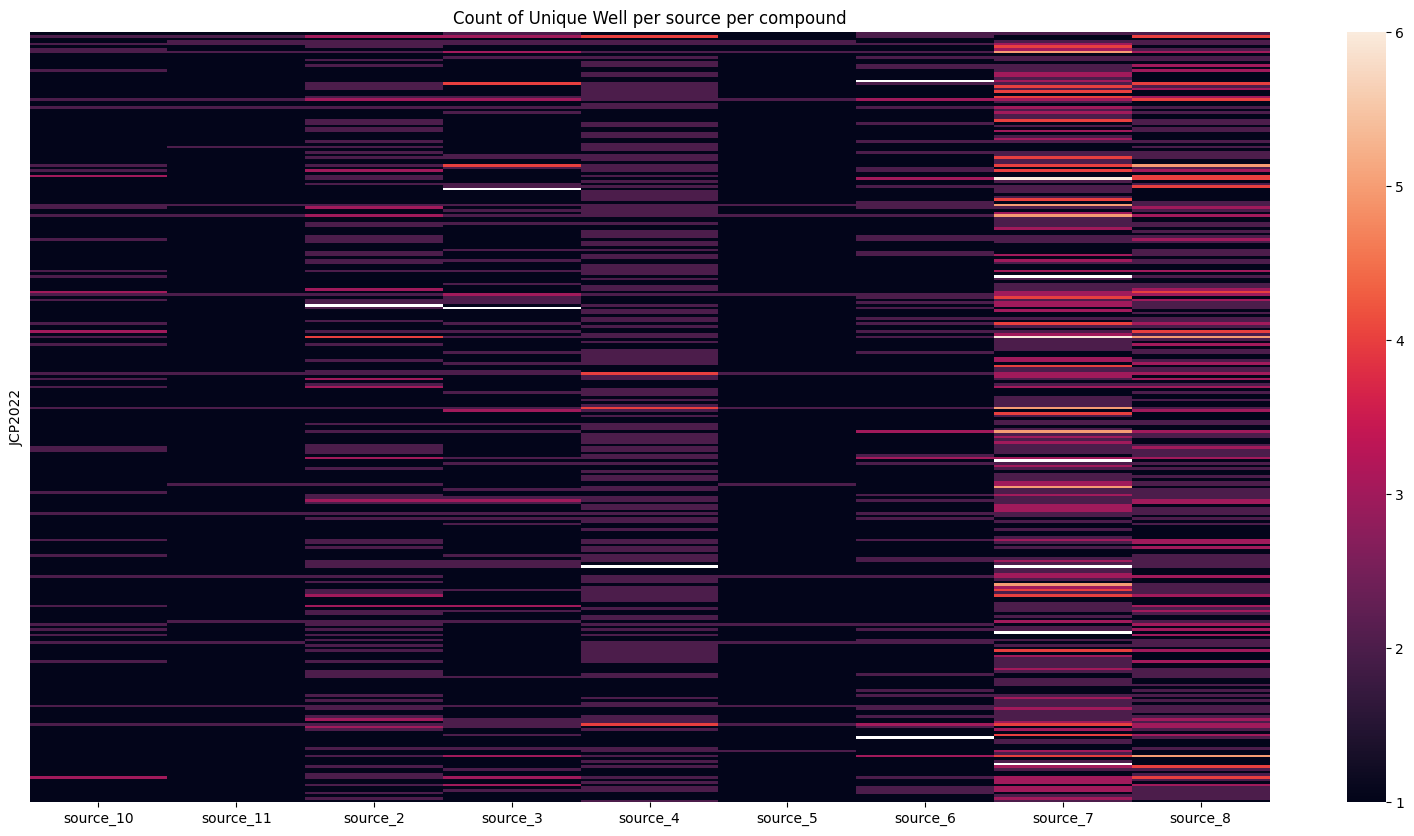

In [34]:
well_p_source_p_compound = (merge_table_filtered.filter(pl.col("Metadata_JCP2022").is_in(controle_name) != True)
                            .group_by(["Metadata_JCP2022", "Metadata_Source"])
 .agg(pl.col("Metadata_JCP2022").count().alias("n_sample"),
      pl.col("Metadata_Well").n_unique().alias("n_well_unique"))
 .sort(by=["Metadata_JCP2022", "Metadata_Source"]))

count_sample_p_source_p_compound = well_p_source_p_compound.pivot(index="Metadata_JCP2022",
                                                                 columns="Metadata_Source",
                                                                 values="n_sample")

unique_well_p_source_p_compound = well_p_source_p_compound.pivot(index="Metadata_JCP2022",
                                                                 columns="Metadata_Source",
                                                                 values="n_well_unique")

fig1, ax1 = plt.subplots(1, figsize=(20,10))
sns.heatmap(count_sample_p_source_p_compound.select(pl.all().exclude("Metadata_JCP2022")),
            ax=ax1)

ax1.set_xticklabels(count_sample_p_source_p_compound.columns[1:])
ax1.tick_params(left = False, labelleft = False)
ax1.set_ylabel("JCP2022")
ax1.set_title("Count of Sample usage per source per compound")

fig2, ax2 = plt.subplots(1, figsize=(20,10))
sns.heatmap(unique_well_p_source_p_compound.select(pl.all().exclude("Metadata_JCP2022")),
            ax=ax2)
           #robust=True)
ax2.set_xticklabels(unique_well_p_source_p_compound.columns[1:])
ax2.tick_params(left = False, labelleft = False)
ax2.set_ylabel("JCP2022")
ax2.set_title("Count of Unique Well per source per compound")

### h) Last Concerns: adding back removed sample from some sources
* Some compounds are not anymore in some sources, let's add them artificially by comparing with the data unfiltered. 

Text(0.5, 1.0, 'Count of Unique Well per source per compound')

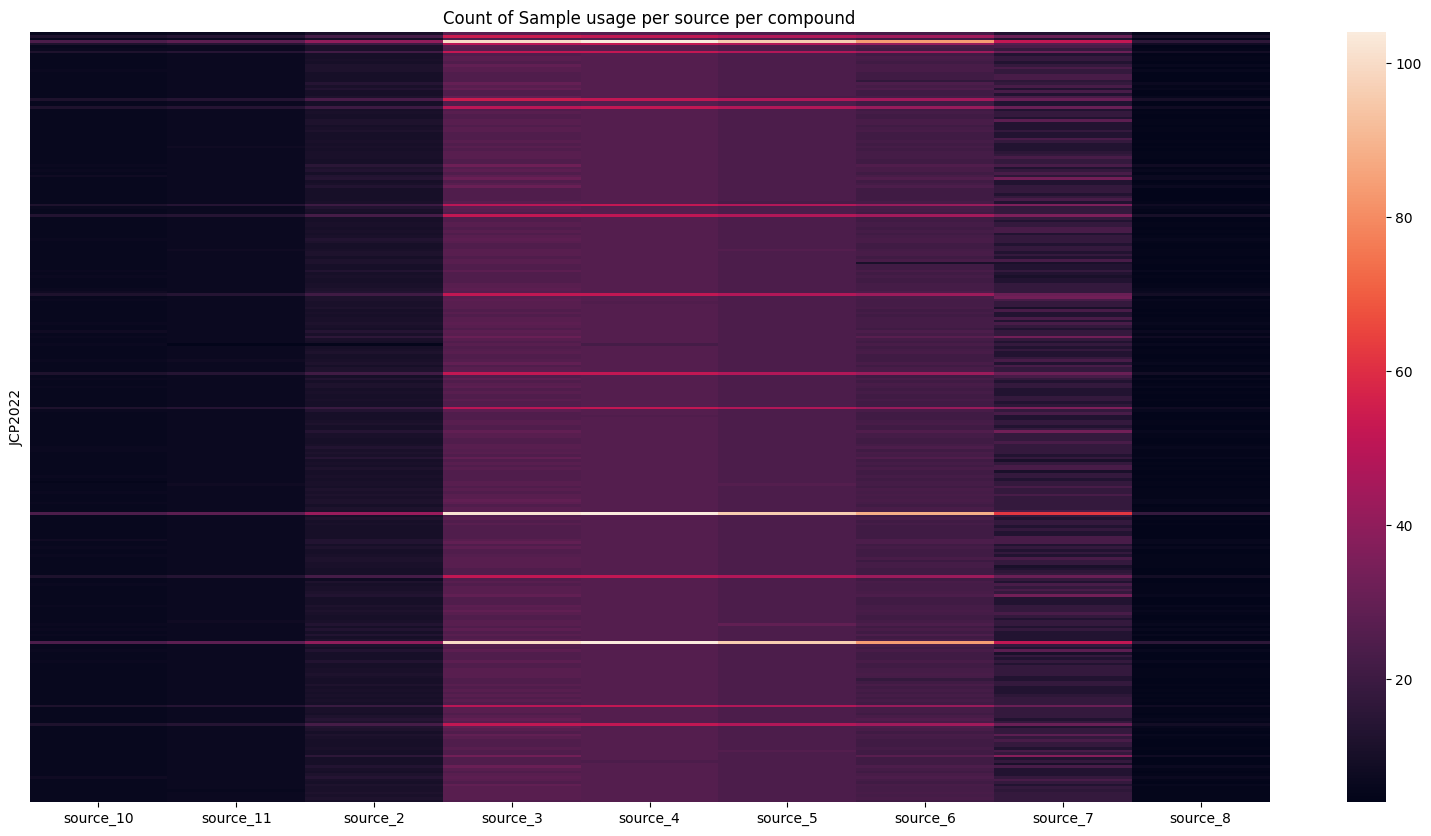

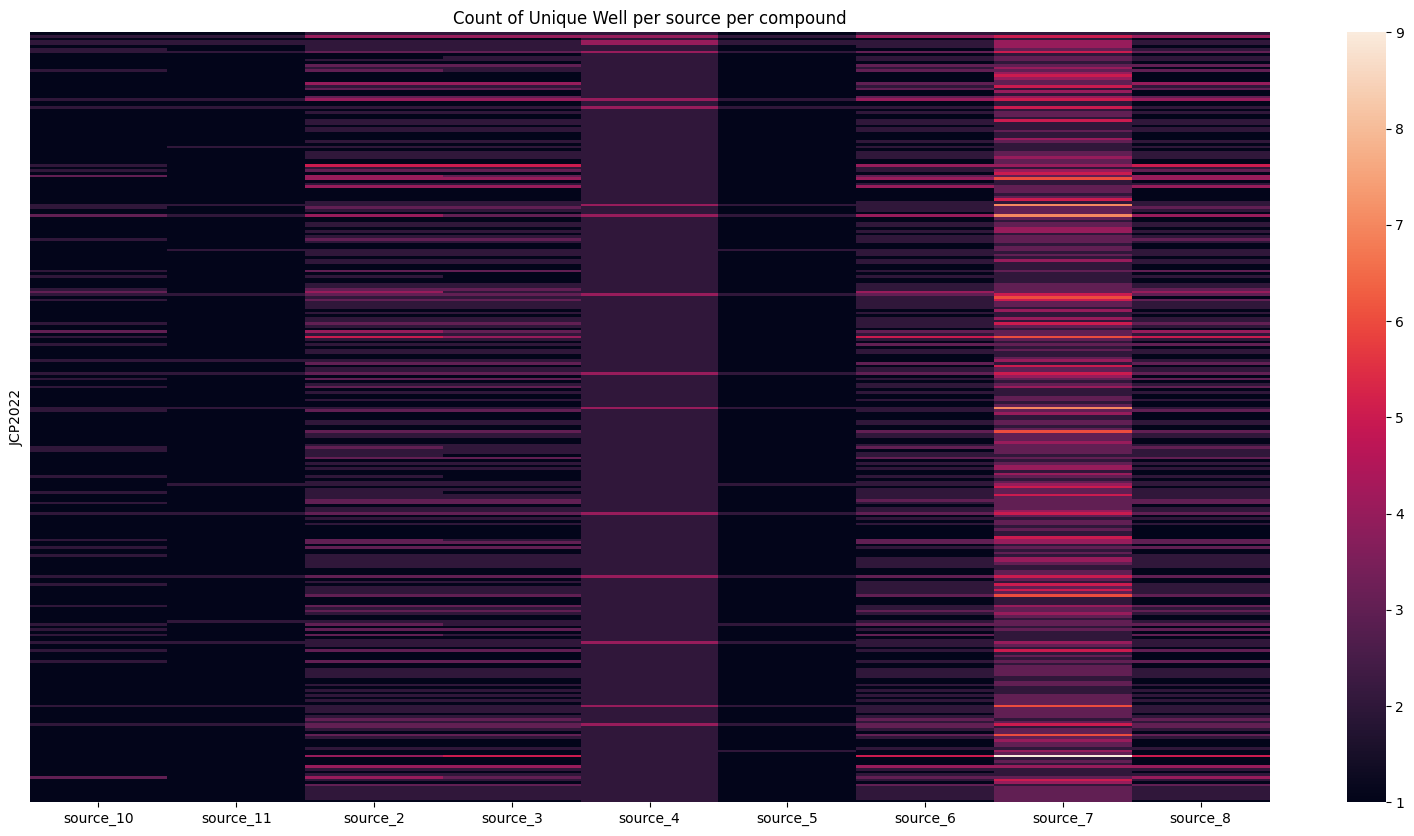

In [35]:
well_p_source_p_compound_raw = (merge_table.filter(pl.col("Metadata_JCP2022").is_in(controle_name) != True)
                            .group_by(["Metadata_JCP2022", "Metadata_Source"])
 .agg(pl.col("Metadata_JCP2022").count().alias("n_sample"),
      pl.col("Metadata_Well").n_unique().alias("n_well_unique"))
 .sort(by=["Metadata_JCP2022", "Metadata_Source"]))

count_sample_p_source_p_compound_raw = well_p_source_p_compound_raw.pivot(index="Metadata_JCP2022",
                                                                 columns="Metadata_Source",
                                                                 values="n_sample")

unique_well_p_source_p_compound_raw = well_p_source_p_compound_raw.pivot(index="Metadata_JCP2022",
                                                                 columns="Metadata_Source",
                                                                 values="n_well_unique")

fig1, ax1 = plt.subplots(1, figsize=(20,10))
sns.heatmap(count_sample_p_source_p_compound_raw.select(pl.all().exclude("Metadata_JCP2022")),
            ax=ax1)

ax1.set_xticklabels(count_sample_p_source_p_compound_raw.columns[1:])
ax1.tick_params(left = False, labelleft = False)
ax1.set_ylabel("JCP2022")
ax1.set_title("Count of Sample usage per source per compound")

fig2, ax2 = plt.subplots(1, figsize=(20,10))
sns.heatmap(unique_well_p_source_p_compound_raw.select(pl.all().exclude("Metadata_JCP2022")),
            ax=ax2)
           #robust=True)
ax2.set_xticklabels(unique_well_p_source_p_compound_raw.columns[1:])
ax2.tick_params(left = False, labelleft = False)
ax2.set_ylabel("JCP2022")
ax2.set_title("Count of Unique Well per source per compound")

In [36]:
#This table compare the amount of sample and unique well use per source and per compounds
well_p_source_p_compound_comp = (well_p_source_p_compound_raw.join(
    well_p_source_p_compound,
    on=["Metadata_JCP2022","Metadata_Source"],
    how="outer",
    suffix="_filter"))
well_p_source_p_compound_comp.head()

Metadata_JCP2022,Metadata_Source,n_sample,n_well_unique,n_sample_filter,n_well_unique_filter
str,str,u32,u32,u32,u32
"""JCP2022_000794…","""source_10""",6,1,3,1
"""JCP2022_000794…","""source_11""",7,1,4,1
"""JCP2022_000794…","""source_2""",11,2,6,1
"""JCP2022_000794…","""source_3""",27,2,6,2
"""JCP2022_000794…","""source_4""",26,2,4,1


Let's compute in average the amount of sample and amount of unique well there is per compounds and per sources
In this way instead of just putting back on sample for each compounds missing in some sources, we add back a coherent amount of samples and wells relative to the average of what exists for this compound in for the sources.  

In [37]:

Sample_mean_p_source_p_compound_comp = (well_p_source_p_compound_comp.select(
    pl.col("Metadata_JCP2022"),
    pl.col("Metadata_Source"),
    pl.col("n_sample_filter").mean().over("Metadata_Source").alias("Source_mean"),
    pl.col("n_sample_filter").mean().over("Metadata_JCP2022").alias("Compound_mean"))
 .with_columns(((pl.col("Source_mean") + pl.col("Compound_mean"))/2).alias("Sample_mean"))
 .select("Metadata_JCP2022", "Metadata_Source", "Sample_mean"))

Well_mean_p_source_p_compound_comp = (well_p_source_p_compound_comp.select(
    pl.col("Metadata_JCP2022"),
    pl.col("Metadata_Source"),
    pl.col("n_well_unique_filter").mean().over("Metadata_Source").alias("Source_mean"),
    pl.col("n_well_unique_filter").mean().over("Metadata_JCP2022").alias("Compound_mean"))
 .with_columns(((pl.col("Source_mean") + pl.col("Compound_mean"))/2).alias("Well_mean"))
 .select("Metadata_JCP2022", "Metadata_Source", "Well_mean"))

mean_p_source_p_compound = (Sample_mean_p_source_p_compound_comp
                                        .join(Well_mean_p_source_p_compound_comp,
                                          on=["Metadata_JCP2022", "Metadata_Source"],
                                          how="outer"))

mean_p_source_p_compound = mean_p_source_p_compound.with_columns(
    pl.col("Sample_mean").round(0),
    pl.col("Well_mean").round(0))

In [38]:
well_p_source_p_compound_comp = well_p_source_p_compound_comp.with_columns(
    pl.col("n_sample_filter", "n_well_unique_filter").fill_null(pl.lit(0)))

In [39]:
compounds_to_retrieve = (well_p_source_p_compound_comp.filter(
    (pl.col("n_well_unique_filter") == 0))
 .join(mean_p_source_p_compound,
       on=["Metadata_JCP2022", "Metadata_Source"],
       how="inner"))

In [40]:
compounds_to_retrieve

Metadata_JCP2022,Metadata_Source,n_sample,n_well_unique,n_sample_filter,n_well_unique_filter,Sample_mean,Well_mean
str,str,u32,u32,u32,u32,f64,f64
"""JCP2022_010382…","""source_6""",17,1,0,0,5.0,1.0
"""JCP2022_030713…","""source_3""",25,1,0,0,5.0,1.0
"""JCP2022_043332…","""source_7""",11,2,0,0,6.0,2.0
"""JCP2022_047545…","""source_2""",11,2,0,0,5.0,1.0
"""JCP2022_047559…","""source_3""",27,2,0,0,5.0,1.0
"""JCP2022_067887…","""source_7""",11,2,0,0,5.0,2.0
"""JCP2022_079617…","""source_4""",26,2,0,0,4.0,2.0
"""JCP2022_079617…","""source_7""",11,2,0,0,4.0,2.0
"""JCP2022_090051…","""source_7""",13,2,0,0,5.0,2.0


Sampling 5 per each compounds is reasonnable and simplify the query. 

In [41]:
compounds_to_retrieve_table = merge_table.join((compounds_to_retrieve
.select(pl.col("Metadata_JCP2022", "Metadata_Source"))),
                 on=["Metadata_JCP2022", "Metadata_Source"],
                 how="inner")

In [42]:
compounds_to_retrieve_table_keep = (compounds_to_retrieve_table
                   .sort(by=["Metadata_JCP2022", "Metadata_Source", 
                             "Metadata_Plate", "Metadata_Well", "Metadata_Batch"]))

compounds_to_retrieve_table_keep = (compounds_to_retrieve_table_keep
                                    .group_by("Metadata_JCP2022", "Metadata_Source")
     .agg(pl.struct(pl.col("Metadata_Plate", "Metadata_Well", "Metadata_Batch"))
          .sort()
          .sample(5, seed=seed))
     .sort(by=["Metadata_JCP2022", "Metadata_Source"])
    .explode("Metadata_Plate")
    .unnest("Metadata_Plate"))


compounds_to_retrieve_table = (compounds_to_retrieve_table.join(compounds_to_retrieve_table_keep,
                         on=["Metadata_Source","Metadata_JCP2022", "Metadata_Plate", 
                             "Metadata_Well", "Metadata_Batch"],
                         how="inner"))

In [43]:
merge_table_filtered2 = merge_table_filtered.join(compounds_to_retrieve_table,
                          on=merge_table_filtered.columns,
                          how="outer")

#### i) Final distributions

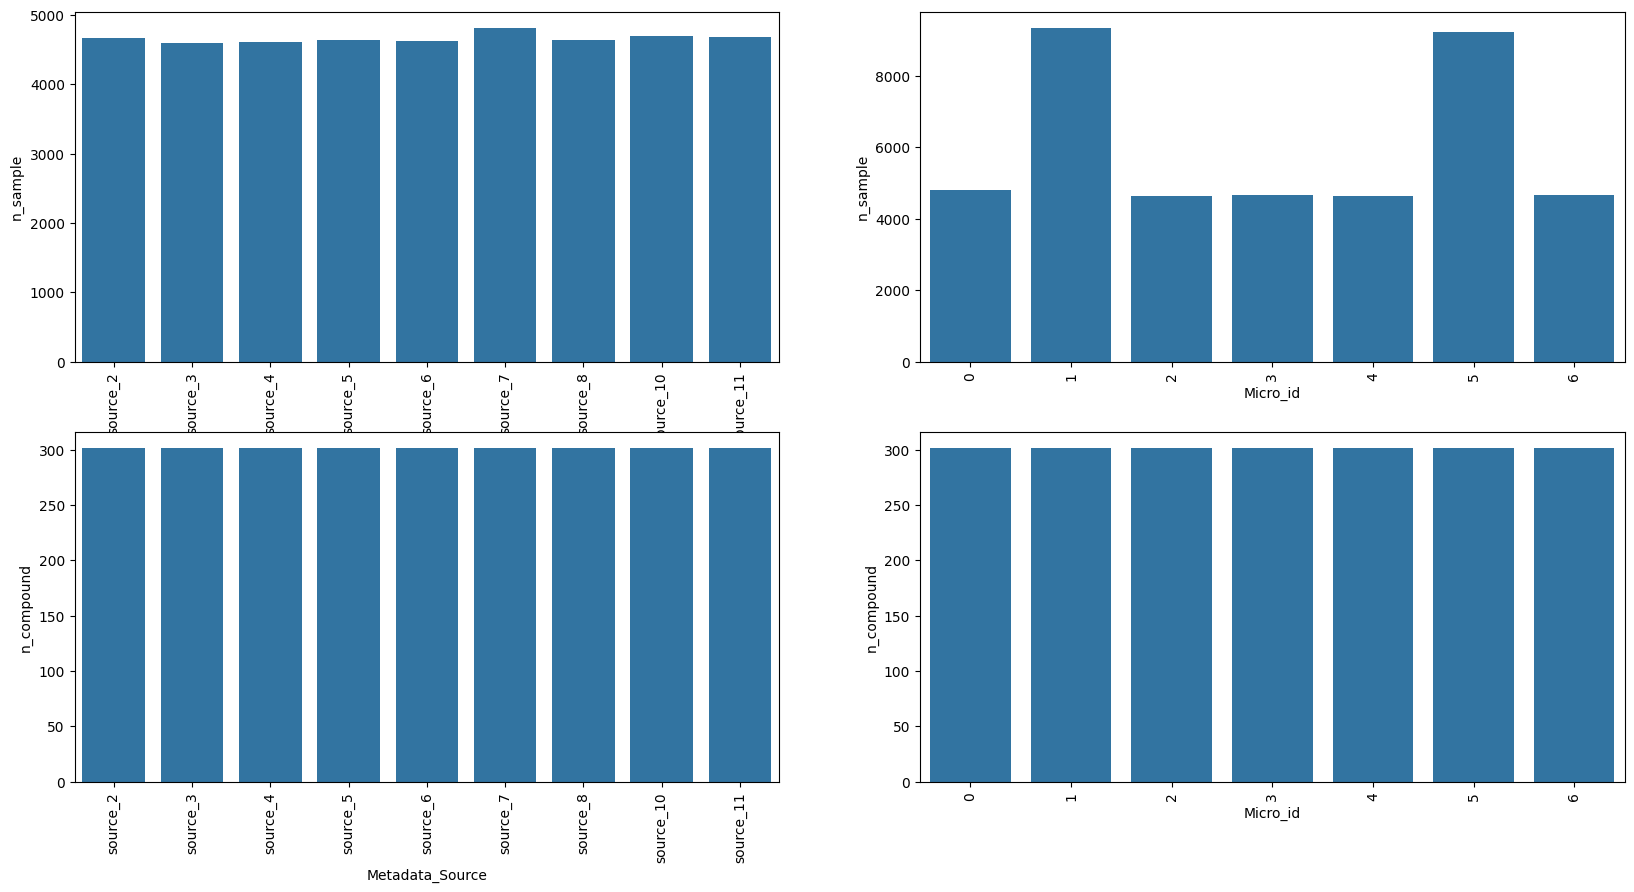

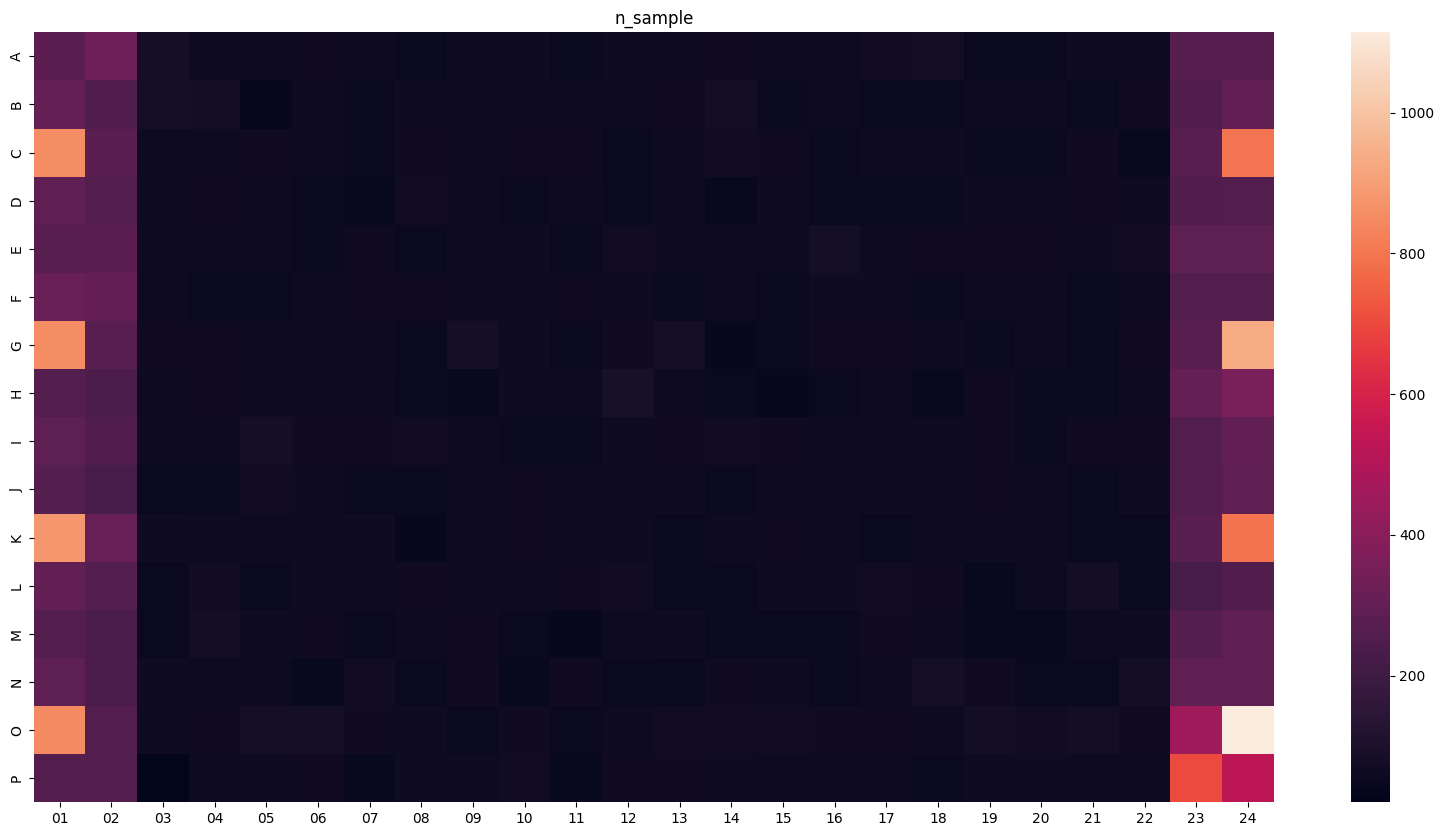

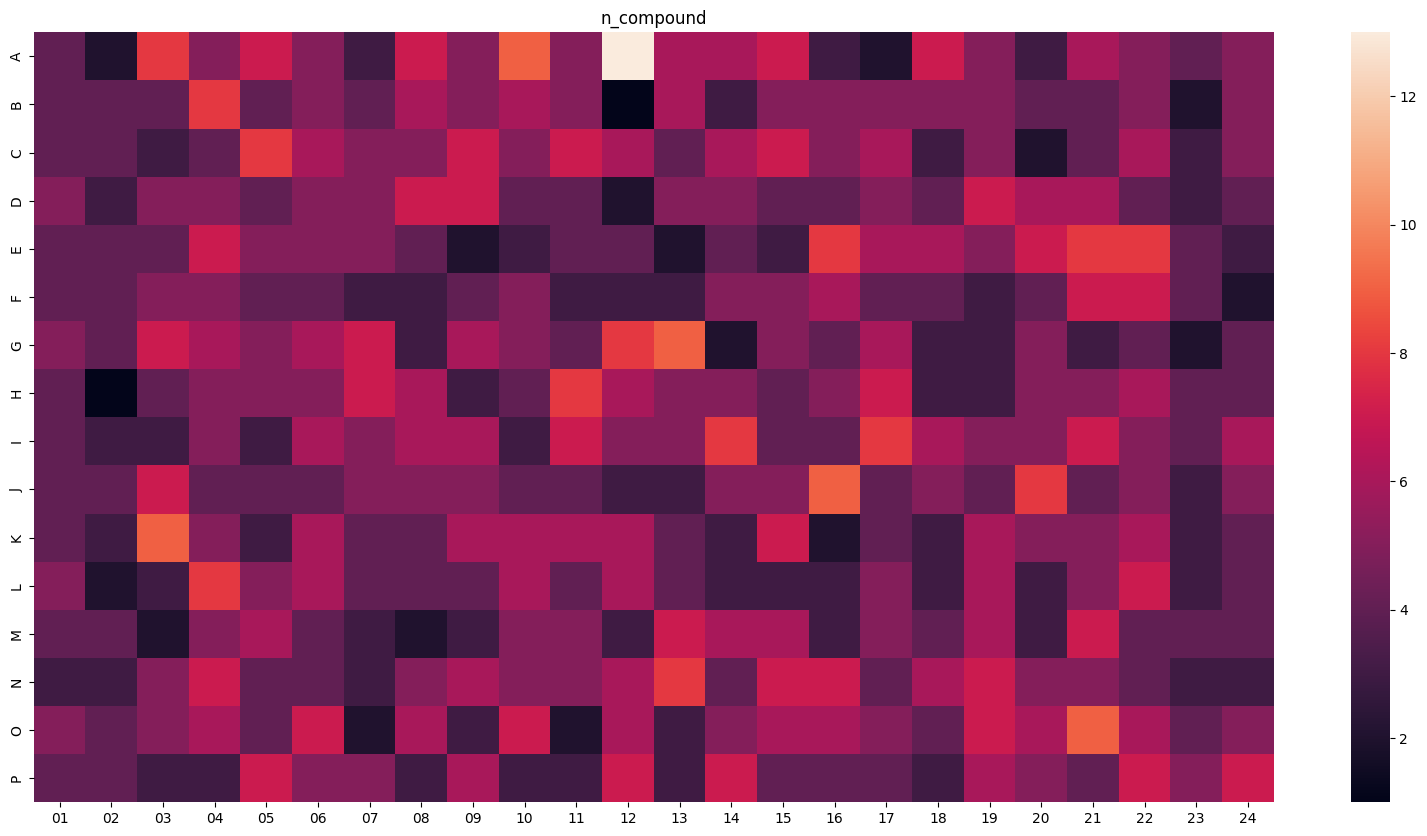

In [44]:
show_distribution(merge_table_filtered2)

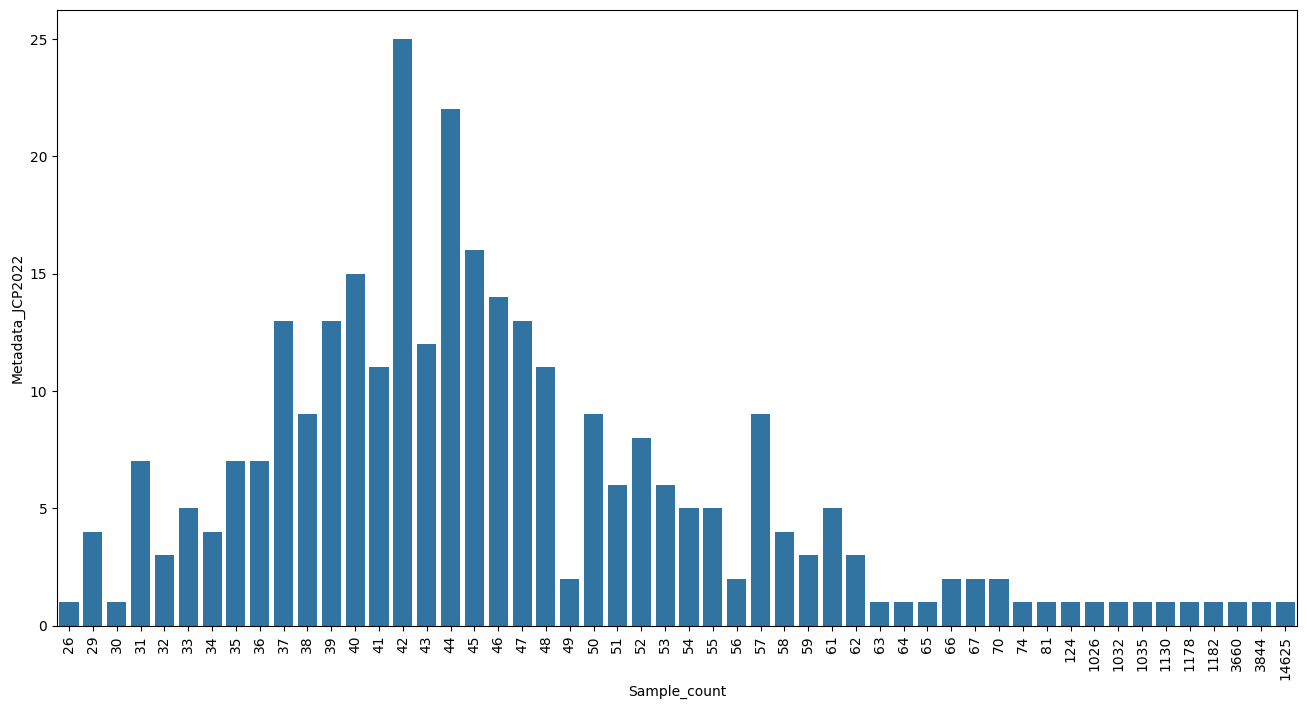

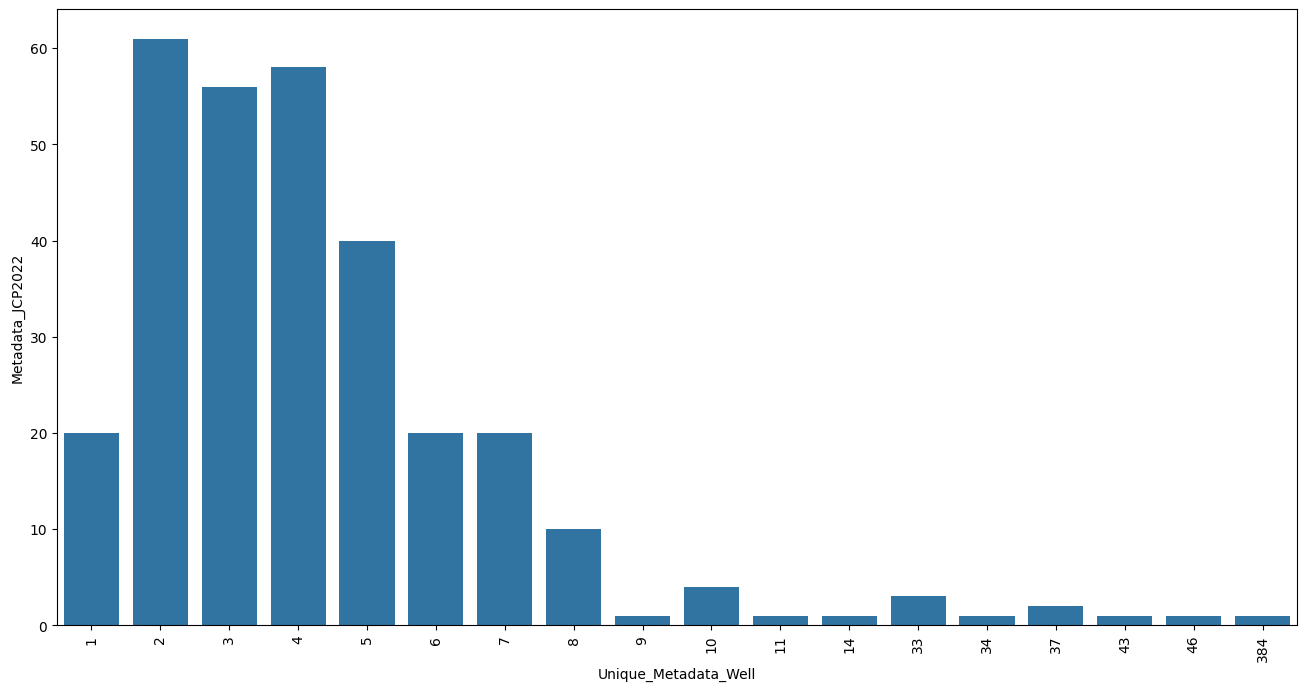

In [45]:
compounds_info_filtered2 = (merge_table_filtered2.group_by("Metadata_JCP2022")
                  .agg(pl.col("Metadata_InChIKey").count().alias("Sample_count"),
                       pl.col("Metadata_Source", "Metadata_Well", "Micro_id")
                       .n_unique().name.prefix("Unique_"))
                       )

fig, ax1 = plt.subplots(1, figsize=(16,8))

df_filtered2 = (compounds_info_filtered2.group_by("Sample_count")
             .agg(pl.col("Metadata_JCP2022").n_unique()).sort(by="Sample_count"))

sns.barplot(df_filtered2,
            x="Sample_count",
            y="Metadata_JCP2022",
            ax=ax1)
ax1.tick_params(axis='x', rotation=90)

fig, ax2 = plt.subplots(1, figsize=(16,8))

df2_filtered2 = (compounds_info_filtered2.group_by("Unique_Metadata_Well")
             .agg(pl.col("Metadata_JCP2022").n_unique()).sort(by="Unique_Metadata_Well"))

sns.barplot(df2_filtered2,
            x="Unique_Metadata_Well",
            y="Metadata_JCP2022",
            ax=ax2)
ax2.tick_params(axis='x', rotation=90)

Text(0.5, 1.0, 'Count of Unique Well per source per compound')

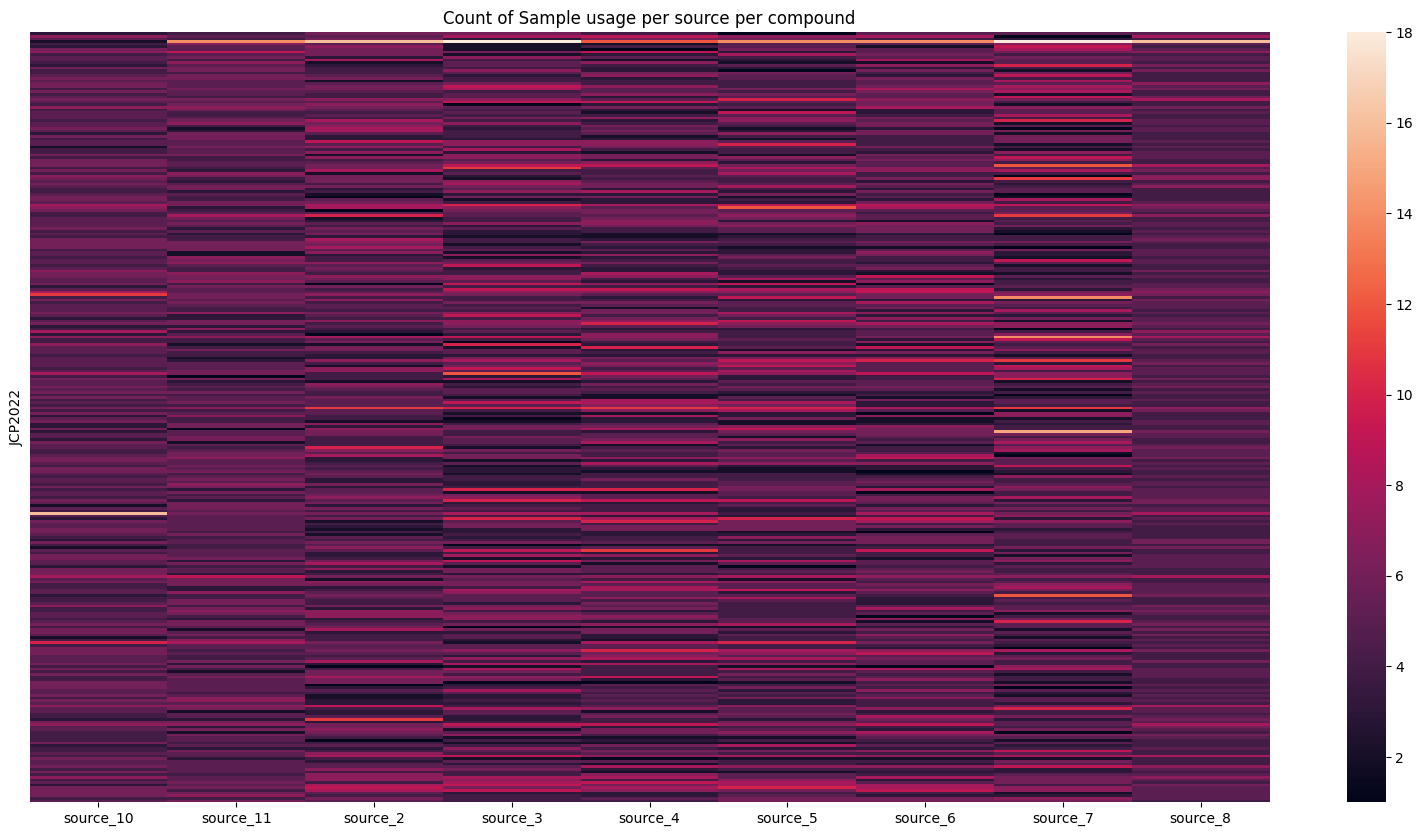

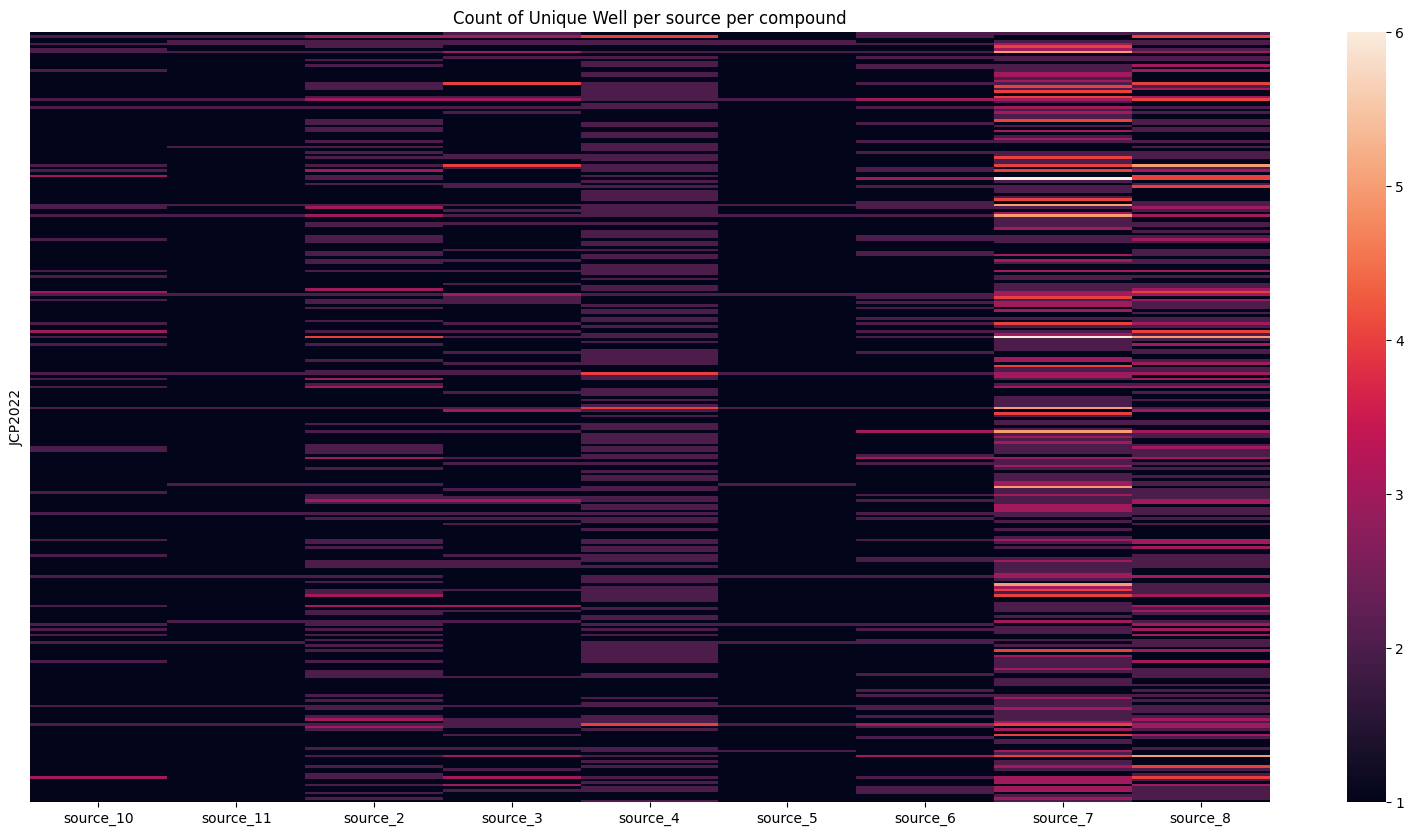

In [46]:
well_p_source_p_compound2 = (merge_table_filtered2.filter(pl.col("Metadata_JCP2022").is_in(controle_name) != True)
                            .group_by(["Metadata_JCP2022", "Metadata_Source"])
 .agg(pl.col("Metadata_JCP2022").count().alias("n_sample"),
      pl.col("Metadata_Well").n_unique().alias("n_well_unique"))
 .sort(by=["Metadata_JCP2022", "Metadata_Source"]))

count_sample_p_source_p_compound2 = well_p_source_p_compound2.pivot(index="Metadata_JCP2022",
                                                                 columns="Metadata_Source",
                                                                 values="n_sample")

unique_well_p_source_p_compound2 = well_p_source_p_compound2.pivot(index="Metadata_JCP2022",
                                                                 columns="Metadata_Source",
                                                                 values="n_well_unique")

fig1, ax1 = plt.subplots(1, figsize=(20,10))
sns.heatmap(count_sample_p_source_p_compound2.select(pl.all().exclude("Metadata_JCP2022")),
            ax=ax1)

ax1.set_xticklabels(count_sample_p_source_p_compound2.columns[1:])
ax1.tick_params(left = False, labelleft = False)
ax1.set_ylabel("JCP2022")
ax1.set_title("Count of Sample usage per source per compound")

fig2, ax2 = plt.subplots(1, figsize=(20,10))
sns.heatmap(unique_well_p_source_p_compound2.select(pl.all().exclude("Metadata_JCP2022")),
            ax=ax2)
           #robust=True)
ax2.set_xticklabels(unique_well_p_source_p_compound2.columns[1:])
ax2.tick_params(left = False, labelleft = False)
ax2.set_ylabel("JCP2022")
ax2.set_title("Count of Unique Well per source per compound")

In [47]:
merge_table_filtered2.shape

(41948, 22)

In [48]:
merge_table_filtered2.group_by("Metadata_Source").agg(pl.col("Metadata_JCP2022").n_unique())

Metadata_Source,Metadata_JCP2022
str,u32
"""source_6""",301
"""source_11""",301
"""source_10""",301
"""source_8""",301
"""source_5""",301
"""source_4""",301
"""source_3""",301
"""source_2""",301
"""source_7""",301


### Adding MOA

In [175]:
merge_table_filtered2 = merge_table_filtered2.with_columns(
    pl.when(pl.col("Metadata_JCP2022").str.contains("JCP2022_050797") &
    pl.col("pert_iname").str.contains("quinine"))
    .then(pl.lit("quinidine"))
    .otherwise(pl.col("pert_iname"))
    .alias("pert_iname"))

In [176]:
moa = pl.read_csv("https://s3.amazonaws.com/data.clue.io/repurposing/downloads/repurposing_drugs_20200324.txt",
            separator="\t",
            comment_prefix="!")

In [177]:
merge_table_filtered_moa = merge_table_filtered2.join(moa.select(
                                                      pl.col("pert_iname", "moa")),
                                                      on="pert_iname",
                                                      how="left")

In [182]:
merge_table_filtered_moa.filter(pl.col("moa").is_null()).select(
    pl.col("Metadata_JCP2022"),
    pl.col("pert_iname"),
    pl.col("moa")).unique()

Metadata_JCP2022,pert_iname,moa
str,str,str
"""JCP2022_076573…","""epothilone-b""",null
"""JCP2022_096342…","""ML-323""",null
"""JCP2022_069668…","""purvalanol-a""",null
"""JCP2022_027911…","""pidolic-acid""",null
"""JCP2022_001275…","""ML-193""",null
"""JCP2022_090768…","""2-Oleoylglycer…",null
"""JCP2022_048971…","""L-Cystine""",null
"""JCP2022_069491…","""cyclosporine""",null
"""JCP2022_088224…","""carzenide""",null


DMSO

In [186]:
merge_table_filtered_moa.write_csv("target2_metadata")

In [196]:
(merge_table_filtered_moa.filter(pl.col("control_type") == "negcon")
                                 .select(pl.struct(pl.col("Metadata_JCP2022", 
                                                 "Metadata_Well", "Metadata_Plate", "Metadata_Source",
                                                 "Metadata_Batch")).n_unique()))

Metadata_JCP2022
u32
14625


In [197]:
(merge_table_filtered_moa.filter(pl.col("control_type") == "negcon"))
                                 # .select(pl.struct(pl.col("Metadata_JCP2022", 
                                 #                 "Metadata_Well", "Metadata_Plate", "Metadata_Source",
                                 #                 "Metadata_Batch")).n_unique()))

Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_Batch,Metadata_PlateType,Metadata_Microscope_Name,Metadata_Widefield_vs_Confocal,Metadata_Excitation_Type,Metadata_Objective_NA,Metadata_Filter_Configuration,Micro_id,broad_sample,pert_iname,pubchem_cid,target,pert_type,control_type,smiles,InChI,moa
str,str,str,str,str,str,str,str,str,str,str,f64,str,u32,str,str,i64,str,str,str,str,str,str
"""JCP2022_033924…","""IAZDPXIOMUYVGZ…","""InChI=1S/C2H6O…","""source_10""","""Dest210628-161…","""K15""","""2021_06_28_U2O…","""DMSO""","""CV8000""","""Confocal""","""Laser""",0.75,"""A""",1,"""NA""","""DMSO""",679,"""NA""","""control""","""negcon""","""C[S+](C)[O-]""","""InChI=1S/C2H6O…","""control vehicl…"
"""JCP2022_033924…","""IAZDPXIOMUYVGZ…","""InChI=1S/C2H6O…","""source_5""","""ATSJUM212""","""M02""","""JUMPCPE-202107…","""COMPOUND""","""CV8000""","""Confocal""","""Laser""",0.75,"""C""",2,"""NA""","""DMSO""",679,"""NA""","""control""","""negcon""","""C[S+](C)[O-]""","""InChI=1S/C2H6O…","""control vehicl…"
"""JCP2022_033924…","""IAZDPXIOMUYVGZ…","""InChI=1S/C2H6O…","""source_3""","""DMSOCP39""","""P12""","""CP60""","""DMSO""","""Opera Phenix""","""Widefield""","""Laser""",1.0,"""B""",5,"""NA""","""DMSO""",679,"""NA""","""control""","""negcon""","""C[S+](C)[O-]""","""InChI=1S/C2H6O…","""control vehicl…"
"""JCP2022_033924…","""IAZDPXIOMUYVGZ…","""InChI=1S/C2H6O…","""source_7""","""CP3-SC2-24M""","""I18""","""20211211_Run9M…","""COMPOUND""","""CV7000""","""Confocal""","""Laser""",0.75,"""D""",0,"""NA""","""DMSO""",679,"""NA""","""control""","""negcon""","""C[S+](C)[O-]""","""InChI=1S/C2H6O…","""control vehicl…"
"""JCP2022_033924…","""IAZDPXIOMUYVGZ…","""InChI=1S/C2H6O…","""source_3""","""DMSOC42""","""I07""","""CP_33_all_Phen…","""DMSO""","""Opera Phenix""","""Widefield""","""Laser""",1.0,"""B""",5,"""NA""","""DMSO""",679,"""NA""","""control""","""negcon""","""C[S+](C)[O-]""","""InChI=1S/C2H6O…","""control vehicl…"
"""JCP2022_033924…","""IAZDPXIOMUYVGZ…","""InChI=1S/C2H6O…","""source_7""","""CP2-SC1-11""","""J23""","""20210723_Run2""","""COMPOUND""","""CV7000""","""Confocal""","""Laser""",0.75,"""D""",0,"""NA""","""DMSO""",679,"""NA""","""control""","""negcon""","""C[S+](C)[O-]""","""InChI=1S/C2H6O…","""control vehicl…"
"""JCP2022_033924…","""IAZDPXIOMUYVGZ…","""InChI=1S/C2H6O…","""source_6""","""110000297109""","""I23""","""p211123CPU2OS4…","""COMPOUND""","""CV8000""","""Confocal""","""Laser""",0.75,"""A""",1,"""NA""","""DMSO""",679,"""NA""","""control""","""negcon""","""C[S+](C)[O-]""","""InChI=1S/C2H6O…","""control vehicl…"
"""JCP2022_033924…","""IAZDPXIOMUYVGZ…","""InChI=1S/C2H6O…","""source_10""","""Dest210622-142…","""O02""","""2021_06_22_U2O…","""DMSO""","""CV8000""","""Confocal""","""Laser""",0.75,"""A""",1,"""NA""","""DMSO""",679,"""NA""","""control""","""negcon""","""C[S+](C)[O-]""","""InChI=1S/C2H6O…","""control vehicl…"
"""JCP2022_033924…","""IAZDPXIOMUYVGZ…","""InChI=1S/C2H6O…","""source_11""","""EC000044""","""D23""","""Batch2""","""COMPOUND""","""Operetta""","""Widefield""","""LED""",1.0,"""F""",6,"""NA""","""DMSO""",679,"""NA""","""control""","""negcon""","""C[S+](C)[O-]""","""InChI=1S/C2H6O…","""control vehicl…"


In [191]:
merge_table_filtered_moa

Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_Batch,Metadata_PlateType,Metadata_Microscope_Name,Metadata_Widefield_vs_Confocal,Metadata_Excitation_Type,Metadata_Objective_NA,Metadata_Filter_Configuration,Micro_id,broad_sample,pert_iname,pubchem_cid,target,pert_type,control_type,smiles,InChI,moa
str,str,str,str,str,str,str,str,str,str,str,f64,str,u32,str,str,i64,str,str,str,str,str,str
"""JCP2022_025848…","""GJFCONYVAUNLKB…","""InChI=1S/C22H2…","""source_2""","""1053601855""","""K01""","""20210607_Batch…","""COMPOUND""","""CV8000""","""Confocal""","""Laser""",1.0,"""A""",3,"""BRD-K38775274-…","""dexamethasone""",5743,"""ANXA1""","""trt""","""NA""","""CC1CC2C3CC=C4C…","""InChI=1S/C22H2…","""glucocorticoid…"
"""JCP2022_050797…","""LOUPRKONTZGTKE…","""InChI=1S/C20H2…","""source_8""","""A1170393""","""C24""","""J1""","""COMPOUND""","""ImageXpress Mi…","""Confocal""","""LED""",0.75,"""E""",4,"""BRD-K48278478-…","""quinidine""",94175,"""KCNN4""","""trt""","""NA""","""C=CC1CN2CCC1CC…","""InChI=1S/C20H2…","""sodium channel…"
"""JCP2022_033924…","""IAZDPXIOMUYVGZ…","""InChI=1S/C2H6O…","""source_10""","""Dest210628-161…","""K15""","""2021_06_28_U2O…","""DMSO""","""CV8000""","""Confocal""","""Laser""",0.75,"""A""",1,"""NA""","""DMSO""",679,"""NA""","""control""","""negcon""","""C[S+](C)[O-]""","""InChI=1S/C2H6O…","""control vehicl…"
"""JCP2022_033924…","""IAZDPXIOMUYVGZ…","""InChI=1S/C2H6O…","""source_5""","""ATSJUM212""","""M02""","""JUMPCPE-202107…","""COMPOUND""","""CV8000""","""Confocal""","""Laser""",0.75,"""C""",2,"""NA""","""DMSO""",679,"""NA""","""control""","""negcon""","""C[S+](C)[O-]""","""InChI=1S/C2H6O…","""control vehicl…"
"""JCP2022_012818…","""CQKBSRPVZZLCJE…","""InChI=1S/C23H1…","""source_11""","""EC000149""","""H01""","""Batch3""","""COMPOUND""","""Operetta""","""Widefield""","""LED""",1.0,"""F""",6,"""BRD-K89517477-…","""TC-S-7004""",57523919,"""DYRK1B""","""control""","""poscon_cp""","""COc1ncc2cc(C(=…","""InChI=1S/C23H1…","""DYRK inhibitor…"
"""JCP2022_085227…","""SRVFFFJZQVENJC…","""InChI=1S/C17H3…","""source_7""","""CP5-SC1-11""","""I01""","""20210803_Run5""","""COMPOUND""","""CV7000""","""Confocal""","""Laser""",0.75,"""D""",0,"""BRD-K91188791-…","""aloxistatin""",65663,"""CTSG""","""trt""","""NA""","""CCOC(=O)C1OC1C…","""InChI=1S/C17H3…","""protease inhib…"
"""JCP2022_025848…","""GJFCONYVAUNLKB…","""InChI=1S/C22H2…","""source_7""","""CP5-SC1-13""","""K01""","""20210803_Run5""","""COMPOUND""","""CV7000""","""Confocal""","""Laser""",0.75,"""D""",0,"""BRD-K38775274-…","""dexamethasone""",5743,"""ANXA1""","""trt""","""NA""","""CC1CC2C3CC=C4C…","""InChI=1S/C22H2…","""glucocorticoid…"
"""JCP2022_025848…","""GJFCONYVAUNLKB…","""InChI=1S/C22H2…","""source_10""","""Dest210809-135…","""O24""","""2021_08_17_U2O…","""COMPOUND""","""CV8000""","""Confocal""","""Laser""",0.75,"""A""",1,"""BRD-A10188456-…","""dexamethasone""",5702035,"""ANXA1""","""trt""","""NA""","""CC1CC2C3CC=C4C…","""InChI=1S/C22H2…","""glucocorticoid…"
"""JCP2022_025848…","""GJFCONYVAUNLKB…","""InChI=1S/C22H2…","""source_6""","""110000295568""","""O24""","""p211004CPU2OS4…","""COMPOUND""","""CV8000""","""Confocal""","""Laser""",0.75,"""A""",1,"""BRD-K38775274-…","""dexamethasone""",5743,"""ANXA1""","""trt""","""NA""","""CC1CC2C3CC=C4C…","""InChI=1S/C22H2…","""glucocorticoid…"
